# 1. Data Loading and Exploration

This section loads the dataset and performs initial exploration to understand the data structure, available features, and streaming log organization.

# Video Quality of Experience (QoE) Prediction Using Machine Learning

## Overview
This notebook implements a comprehensive QoE prediction system for adaptive video streaming based on machine learning techniques. The analysis follows a structured pipeline:

1. **Data Loading & Exploration**: Load and inspect the dataset structure
2. **Feature Aggregation**: Aggregate streaming log statistics
3. **Feature Engineering**: Create derived features for improved prediction
4. **Baseline Model Comparison**: Evaluate multiple ML algorithms
5. **Decision Tree Analysis**: In-depth analysis with the optimal model

## Dataset Description
- **Source**: Video streaming quality dataset with MOS scores
- **Streaming Logs**: Individual session logs containing per-chunk metrics
- **Target Variable**: Mean Opinion Score (MOS) ranging from 1-5

In [120]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Base paths
base_path = "data"
feature_profile_path = os.path.join(base_path, "feature_profiles")
streaming_logs_path = os.path.join(base_path, "streaming_logs")
main_csv_path = os.path.join(base_path, "data.csv")

# Check if paths exist
print("=== Path Verification ===")
print(f"Base path exists: {os.path.exists(base_path)}")
print(f"Feature Profiles path exists: {os.path.exists(feature_profile_path)}")
print(f"Streaming Logs path exists: {os.path.exists(streaming_logs_path)}")
print(f"Main CSV exists: {os.path.exists(main_csv_path)}")

# Load main dataset (data.csv)
print("\n=== Main Dataset (data.csv) ===")
df_main = pd.read_csv(main_csv_path)
print(f"Shape: {df_main.shape}")
print(f"Columns: {df_main.columns.tolist()}")
print("\nFirst 5 rows:")
print(df_main.head())
print("\nDataset Info:")
print(df_main.info())

# List all streaming log files
print("\n=== Streaming Logs ===")
streaming_files = [f for f in os.listdir(streaming_logs_path) if f.endswith('.csv')]
print(f"Total streaming log files: {len(streaming_files)}")
print(f"Sample files: {streaming_files[:10]}")

# Inspect example streaming log file
example_log_path = os.path.join(streaming_logs_path, streaming_files[0])
print(f"\n=== Example Streaming Log: {streaming_files[0]} ===")
df_log = pd.read_csv(example_log_path)
print(f"Shape: {df_log.shape}")
print(f"Columns: {df_log.columns.tolist()}")
print("\nFirst 5 rows:")
print(df_log.head())

# List feature profile files
print("\n=== Feature Profiles ===")
feature_files = [f for f in os.listdir(feature_profile_path) if f.endswith('.csv')]
print(f"Total feature profile files: {len(feature_files)}")
print(f"Files: {feature_files}")

=== Path Verification ===
Base path exists: True
Feature Profiles path exists: True
Streaming Logs path exists: True
Main CSV exists: True

=== Main Dataset (data.csv) ===
Shape: (450, 5)
Columns: ['streaming_log', 'mos', 'content', 'encoding_profile', 'device']

First 5 rows:
  streaming_log    mos       content encoding_profile device
0       001.csv  31.38  BigBuckBunny             H264   hdtv
1       002.csv  51.01  BigBuckBunny             H264   hdtv
2       003.csv  48.95  BigBuckBunny             H264   hdtv
3       004.csv  58.34  BigBuckBunny             H264   hdtv
4       005.csv  62.82  BigBuckBunny             H264   hdtv

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   streaming_log     450 non-null    object 
 1   mos               450 non-null    float64
 2   content           450 non-null    object 
 3

## 1.1 Initial Data Visualization

Visualize the distribution of MOS scores and key metadata to understand the dataset characteristics.

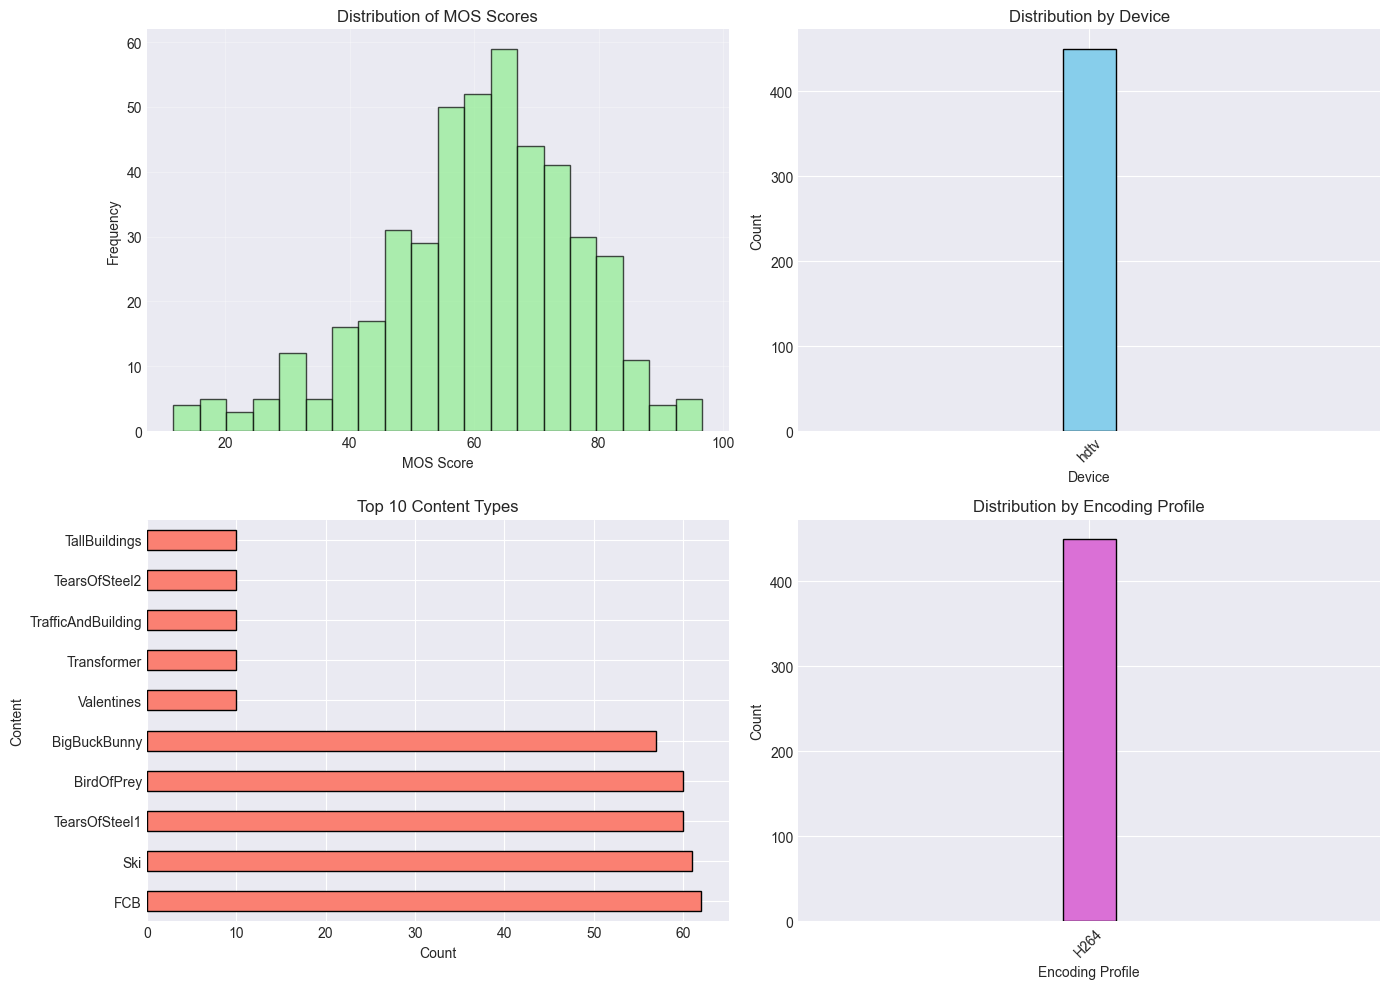


=== MOS Statistical Summary ===
count    450.000000
mean      60.867022
std       15.511230
min       11.680000
25%       52.512500
50%       62.270000
75%       71.557500
max       96.630000
Name: mos, dtype: float64


In [121]:
# Visualize MOS distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# MOS distribution
axes[0, 0].hist(df_main['mos'], bins=20, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 0].set_xlabel('MOS Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of MOS Scores')
axes[0, 0].grid(True, alpha=0.3)

# Device distribution
df_main['device'].value_counts().plot(kind='bar', ax=axes[0, 1], edgecolor='black', color='skyblue', width=0.05)
axes[0, 1].set_xlabel('Device')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Distribution by Device')
axes[0, 1].tick_params(axis='x', rotation=45)

# Content distribution
df_main['content'].value_counts().head(10).plot(kind='barh', ax=axes[1, 0], edgecolor='black', color='salmon')
axes[1, 0].set_xlabel('Count')
axes[1, 0].set_ylabel('Content')
axes[1, 0].set_title('Top 10 Content Types')

# Encoding profile distribution
df_main['encoding_profile'].value_counts().plot(kind='bar', ax=axes[1, 1], edgecolor='black', color='orchid', width=0.05)
axes[1, 1].set_xlabel('Encoding Profile')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Distribution by Encoding Profile')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Statistical summary
print("\n=== MOS Statistical Summary ===")
print(df_main['mos'].describe())

# 2. Feature Aggregation from Streaming Logs

This section aggregates statistical features from individual streaming log files. Each log contains per-chunk metrics including:
- **Quality metrics**: PSNR, SSIM, VMAF
- **Bitrate metrics**: Video bitrate variations
- **Rebuffering metrics**: Stall events and durations
- **Temporal metrics**: Chunk duration and timing

Statistical summaries (mean, std, min, max) are computed for each metric to create a feature vector for ML models.

In [122]:
import os
import pandas as pd
from tqdm import tqdm

# Define paths
base_path = r"data"
main_csv = os.path.join(base_path, "data.csv")
logs_path = os.path.join(base_path, "streaming_logs")

# Read main dataset
main_df = pd.read_csv(main_csv)
print(f"Processing {len(main_df)} streaming sessions...")

# Prepare list to collect processed log features
aggregated_features = []
missing_logs = []

print("\n=== Aggregating Streaming Log Features ===")

for idx, row in tqdm(main_df.iterrows(), total=len(main_df), desc="Processing logs"):
    log_file = os.path.join(logs_path, row['streaming_log'])
    
    if not os.path.exists(log_file):
        missing_logs.append(row['streaming_log'])
        continue
    
    log_df = pd.read_csv(log_file)
    
    # Exclude representation_index from statistical aggregation (it's just an index, not actual data)
    numeric_cols = [col for col in log_df.select_dtypes(include=[np.number]).columns 
                    if col != 'representation_index']
    
    # Compute statistical summaries for numeric columns (excluding representation_index)
    stats = log_df[numeric_cols].describe().loc[['mean', 'std', 'min', 'max']].to_dict()
    
    # Flatten nested dict to one row
    flattened = {f"{col}_{stat}": val for col, vals in stats.items() for stat, val in vals.items()}
    
    # Add identifying columns and target variable
    flattened.update({
        "index": idx,  # Add index column
        "streaming_log": row['streaming_log'],
        "mos": row['mos'],
        "content": row['content'],
        "encoding_profile": row['encoding_profile'],
        "device": row['device']
    })
    
    aggregated_features.append(flattened)

# Create final dataframe
final_df = pd.DataFrame(aggregated_features)

# Reorder columns to place index first
cols = ['index'] + [col for col in final_df.columns if col != 'index']
final_df = final_df[cols]

print("\n=== Combined Dataset Statistics ===")
print(f"Total sessions processed: {len(final_df)}")
print(f"Missing log files: {len(missing_logs)}")
print(f"Feature dimensions: {final_df.shape}")
print(f"Total features: {len(final_df.columns)} columns")
print(f"\nFeature columns: {final_df.columns.tolist()[:10]}")
print("\nFirst 5 rows:")
print(final_df.head())

# Save for reuse
output_path = os.path.join(base_path, "combined_dataset.csv")
final_df.to_csv(output_path, index=False)
print(f"\nDataset saved to: {output_path}")

Processing 450 streaming sessions...

=== Aggregating Streaming Log Features ===


Processing logs: 100%|██████████| 450/450 [00:07<00:00, 56.56it/s]


=== Combined Dataset Statistics ===
Total sessions processed: 450
Missing log files: 0
Feature dimensions: (450, 70)
Total features: 70 columns

Feature columns: ['index', 'rebuffering_duration_mean', 'rebuffering_duration_std', 'rebuffering_duration_min', 'rebuffering_duration_max', 'video_bitrate_mean', 'video_bitrate_std', 'video_bitrate_min', 'video_bitrate_max', 'chunk_duration_mean']

First 5 rows:
   index  rebuffering_duration_mean  rebuffering_duration_std  \
0      0                     0.8066                  0.680119   
1      1                     0.1066                  0.238365   
2      2                     0.1400                  0.313050   
3      3                     0.0534                  0.119406   
4      4                     0.0400                  0.089443   

   rebuffering_duration_min  rebuffering_duration_max  video_bitrate_mean  \
0                       0.0                     1.800            221.5648   
1                       0.0                   

# 3. Feature Engineering

Advanced feature engineering is performed to capture complex relationships between quality metrics and QoE:

## 3.1 Engineered Feature Categories

### Quality-Rebuffering Ratios
- Captures the trade-off between perceived quality and interruptions
- Features: `psnr_per_rebuffer`, `ssim_per_rebuffer`, `vmaf_per_rebuffer`

### Bitrate-Quality Efficiency
- Measures encoding efficiency (quality per unit bitrate)
- Features: `bitrate_per_psnr`, `bitrate_per_ssim`, `bitrate_per_vmaf`

### Quality Stability Indicators
- Quantifies quality variation across chunks (important for QoE)
- Features: `psnr_range`, `ssim_range`, `vmaf_range`

### Rebuffering Statistics
- Normalized rebuffering metrics
- Features: `rebuffering_ratio`, `rebuffering_std_ratio`

### Interaction Features
- Captures synergistic effects between metrics
- Features: `bitrate_x_vmaf`, `ssim_x_vmaf`

In [123]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load combined dataset
df = pd.read_csv(r"data\combined_dataset.csv")
print(f"Original dataset shape: {df.shape}")

# ===========================
# FEATURE ENGINEERING
# ===========================

print("\n=== Creating Engineered Features ===\n")

# Quality vs rebuffering ratios
print("1. Quality-Rebuffering Ratios")
df['psnr_per_rebuffer'] = df['psnr_mean'] / (df['rebuffering_duration_mean'] + 1e-5)
df['ssim_per_rebuffer'] = df['ssim_mean'] / (df['rebuffering_duration_mean'] + 1e-5)
df['vmaf_per_rebuffer'] = df['vmaf_mean'] / (df['rebuffering_duration_mean'] + 1e-5)

# Bitrate vs quality efficiency
print("2. Bitrate-Quality Efficiency")
df['bitrate_per_psnr'] = df['video_bitrate_mean'] / (df['psnr_mean'] + 1e-5)
df['bitrate_per_ssim'] = df['video_bitrate_mean'] / (df['ssim_mean'] + 1e-5)
df['bitrate_per_vmaf'] = df['video_bitrate_mean'] / (df['vmaf_mean'] + 1e-5)

# Quality stability features (variation across chunks)
print("3. Quality Stability Indicators")
df['psnr_range'] = df['psnr_max'] - df['psnr_min']
df['ssim_range'] = df['ssim_max'] - df['ssim_min']
df['vmaf_range'] = df['vmaf_max'] - df['vmaf_min']

# Rebuffering statistics
print("4. Rebuffering Statistics")
df['rebuffering_ratio'] = df['rebuffering_duration_max'] / (df['chunk_duration_max'] + 1e-5)
df['rebuffering_std_ratio'] = df['rebuffering_duration_std'] / (df['rebuffering_duration_mean'] + 1e-5)

# Interaction features
print("5. Interaction Features")
df['bitrate_x_vmaf'] = df['video_bitrate_mean'] * df['vmaf_mean']
df['ssim_x_vmaf'] = df['ssim_mean'] * df['vmaf_mean']

# Encode categorical features
print("6. Encoding Categorical Variables")
categorical_cols = ['device', 'content', 'encoding_profile']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"   - {col}: {len(le.classes_)} unique values")

# Save feature-engineered dataset
output_path = r"data\combined_dataset_fe.csv"
df.to_csv(output_path, index=False)
print(f"\n=== Feature Engineering Complete ===")
print(f"Output saved to: {output_path}")
print(f"Final dataset shape: {df.shape}")
print(f"\nNew features created: {df.shape[1] - pd.read_csv('data/combined_dataset.csv').shape[1]}")
print(f"\nSample of feature-engineered data:")
print(df.head())

Original dataset shape: (450, 70)

=== Creating Engineered Features ===

1. Quality-Rebuffering Ratios
2. Bitrate-Quality Efficiency
3. Quality Stability Indicators
4. Rebuffering Statistics
5. Interaction Features
6. Encoding Categorical Variables
   - device: 1 unique values
   - content: 20 unique values
   - encoding_profile: 1 unique values

=== Feature Engineering Complete ===
Output saved to: data\combined_dataset_fe.csv
Final dataset shape: (450, 83)

New features created: 13

Sample of feature-engineered data:
   index  rebuffering_duration_mean  rebuffering_duration_std  \
0      0                     0.8066                  0.680119   
1      1                     0.1066                  0.238365   
2      2                     0.1400                  0.313050   
3      3                     0.0534                  0.119406   
4      4                     0.0400                  0.089443   

   rebuffering_duration_min  rebuffering_duration_max  video_bitrate_mean  \
0      

## 3.2 Feature Correlation Analysis

Analyze correlations between engineered features and MOS to identify the most influential factors for QoE prediction.

=== Top 15 Features Correlated with MOS ===

mos              1.000000
vmaf_mean        0.672258
ssim_x_vmaf      0.662951
ssimplus_mean    0.612494
vmaf_min         0.605077
msssim_mean      0.589490
ssimplus_min     0.577351
vmaf_max         0.567268
msssim_min       0.554178
height_min       0.541086
height_mean      0.540799
ssimplus_max     0.533276
width_mean       0.527968
msssim_max       0.524225
psnr_mean        0.495272
width_max        0.486526
Name: mos, dtype: float64

=== Bottom 15 Features Correlated with MOS ===

mvm_mean              -0.550153
vqm_max               -0.571993
vqm_min               -0.615877
vqm_mean              -0.671644
chunk_duration_mean         NaN
chunk_duration_std          NaN
chunk_duration_min          NaN
chunk_duration_max          NaN
framerate_std               NaN
is_best_mean                NaN
is_best_std                 NaN
is_best_min                 NaN
is_best_max                 NaN
encoding_profile            NaN
device          

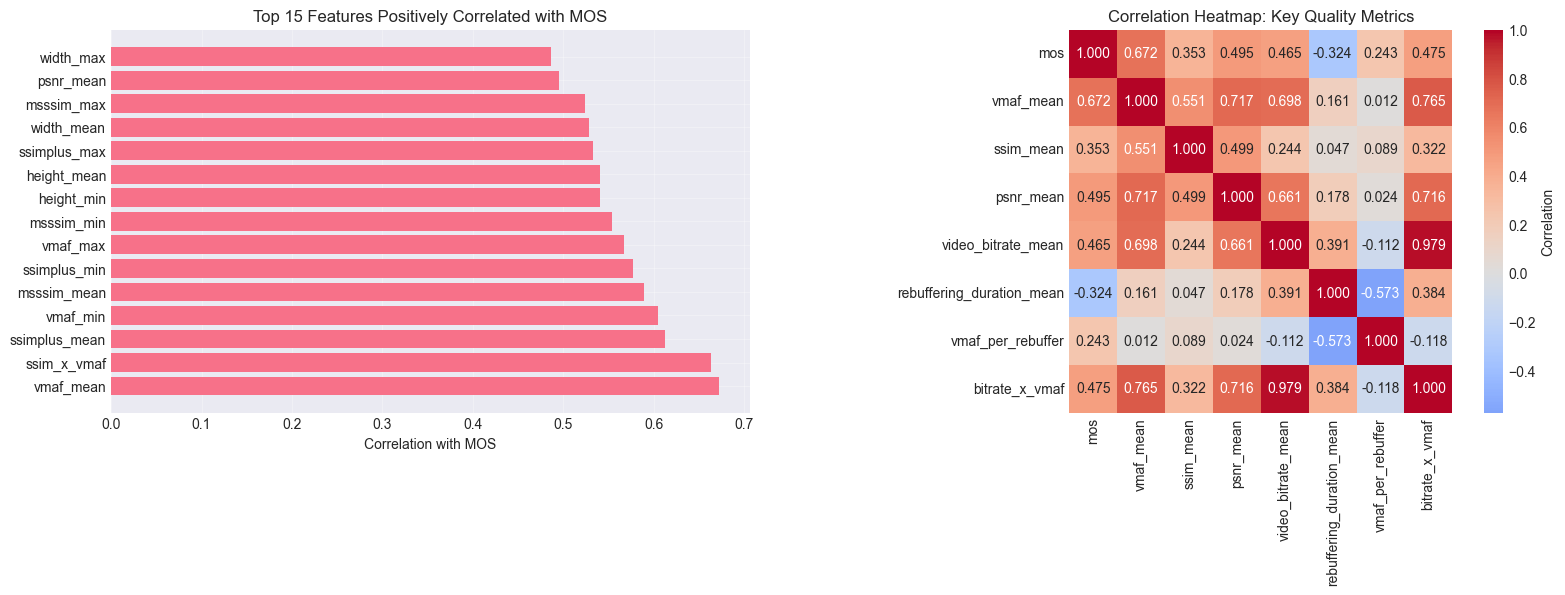

In [124]:
# Correlation analysis with MOS
# Use only numeric columns to avoid attempting to convert string/object columns (e.g., streaming_log) to floats
numeric_df = df.select_dtypes(include=[np.number])

if 'mos' not in numeric_df.columns:
    raise KeyError("MOS column is not numeric or is missing from the dataframe.")

correlations = numeric_df.corr()['mos'].sort_values(ascending=False)

# Display top correlations
print("=== Top 15 Features Correlated with MOS ===\n")
print(correlations.head(16))  # Top 15 + MOS itself

print("\n=== Bottom 15 Features Correlated with MOS ===\n")
print(correlations.tail(15))

# Visualize top correlations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top positive correlations (exclude mos itself)
top_features = correlations.drop(labels=['mos']).head(15)
axes[0].barh(range(len(top_features)), top_features.values)
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features.index)
axes[0].set_xlabel('Correlation with MOS')
axes[0].set_title('Top 15 Features Positively Correlated with MOS')
axes[0].grid(True, alpha=0.3)

# Correlation heatmap for key quality metrics (only use metrics that exist and are numeric)
key_metrics = ['mos', 'vmaf_mean', 'ssim_mean', 'psnr_mean',
               'video_bitrate_mean', 'rebuffering_duration_mean',
               'vmaf_per_rebuffer', 'bitrate_x_vmaf']
present_metrics = [k for k in key_metrics if k in df.columns and np.issubdtype(df[k].dtype, np.number)]

if len(present_metrics) < 2:
    axes[1].text(0.5, 0.5, 'Not enough numeric key metrics for heatmap', ha='center', va='center')
    axes[1].set_axis_off()
else:
    corr_matrix = df[present_metrics].corr()
    sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm',
                center=0, ax=axes[1], square=True, cbar_kws={'label': 'Correlation'})
    axes[1].set_title('Correlation Heatmap: Key Quality Metrics')

plt.tight_layout()
plt.show()

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Load feature-engineered dataset
df = pd.read_csv(r"data\combined_dataset_fe.csv")
print("="*70)
print("DATA PREPARATION FOR MODEL TRAINING")
print("="*70)
print(f"\nDataset shape: {df.shape}")

# Prepare features and target
X = df.drop(columns=['mos', 'streaming_log'])  # Remove target and identifier
y = df['mos']

print(f"Features: {X.shape[1]} columns")
print(f"Target: MOS (range: {y.min():.2f} - {y.max():.2f})")
print(f"Total samples: {len(y)}")

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)
print(f"\n--- Data Split (80-20) ---")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(y)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(y)*100:.1f}%)")

# Feature standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"\n--- Feature Standardization ---")
print("Features standardized to zero mean and unit variance")
print(f"Training data shape: {X_train_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")

# Setup for cross-validation
CV_FOLDS = 5
kf = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=42)
print(f"\n--- Cross-Validation Setup ---")
print(f"K-Fold CV: {CV_FOLDS} folds")

# Dictionary to store all model results
all_model_results = []

print("\n" + "="*70)
print("DATA PREPARATION COMPLETE - READY FOR MODEL TRAINING")
print("="*70)

DATA PREPARATION FOR MODEL TRAINING

Dataset shape: (450, 83)
Features: 81 columns
Target: MOS (range: 11.68 - 96.63)
Total samples: 450

--- Data Split (80-20) ---
Training set: 360 samples (80.0%)
Test set: 90 samples (20.0%)

--- Feature Standardization ---
Features standardized to zero mean and unit variance
Training data shape: (360, 81)
Test data shape: (90, 81)

--- Cross-Validation Setup ---
K-Fold CV: 5 folds

DATA PREPARATION COMPLETE - READY FOR MODEL TRAINING


## 4.0 Data Preparation for Model Training

Prepare the dataset with train-test split and feature standardization for all models.

# 4. Machine Learning Models for QoE Prediction

This section implements 7 different machine learning algorithms as per the research methodology. Each model is trained, evaluated, and analyzed independently with comprehensive metrics.

## Evaluation Metrics
- **MSE** (Mean Squared Error): Average squared difference between predicted and actual MOS
- **RMSE** (Root Mean Squared Error): Square root of MSE, in same units as MOS
- **MAE** (Mean Absolute Error): Average absolute difference
- **R²** (Coefficient of Determination): Proportion of variance explained (0-1, higher is better)
- **PLCC** (Pearson Linear Correlation Coefficient): Linear correlation between predictions and actual values
- **SRCC** (Spearman Rank Correlation Coefficient): Monotonic correlation (rank-based)

## Models Implemented
1. **Linear Regression** - Baseline linear model
2. **Decision Tree** - Tree-based non-linear model
3. **Random Forest** - Ensemble of decision trees
4. **Gradient Boosting** - Sequential ensemble learning
5. **Support Vector Regression (SVR)** - Kernel-based regression
6. **K-Nearest Neighbors (KNN)** - Instance-based learning
7. **Multi-Layer Perceptron (MLP)** - Neural network approach

## 4.1 Model 1: Linear Regression

Linear Regression serves as the baseline model, assuming a linear relationship between features and QoE. This model provides a benchmark for comparison with more complex algorithms.

MODEL 1: LINEAR REGRESSION

[1/3] Performing 5-Fold Cross-Validation...
CV R² scores: ['0.7424', '0.7181', '0.7031', '-1.3774', '0.6551']
Mean CV R²: 0.2883 ± 0.8333

[2/3] Training Linear Regression model...
Training complete!

[3/3] Evaluating on test set...

LINEAR REGRESSION - TEST SET RESULTS
MSE:   67.841468
RMSE:  8.236593
MAE:   6.139451
R²:    0.738393
PLCC:  0.880796
SRCC:  0.877252


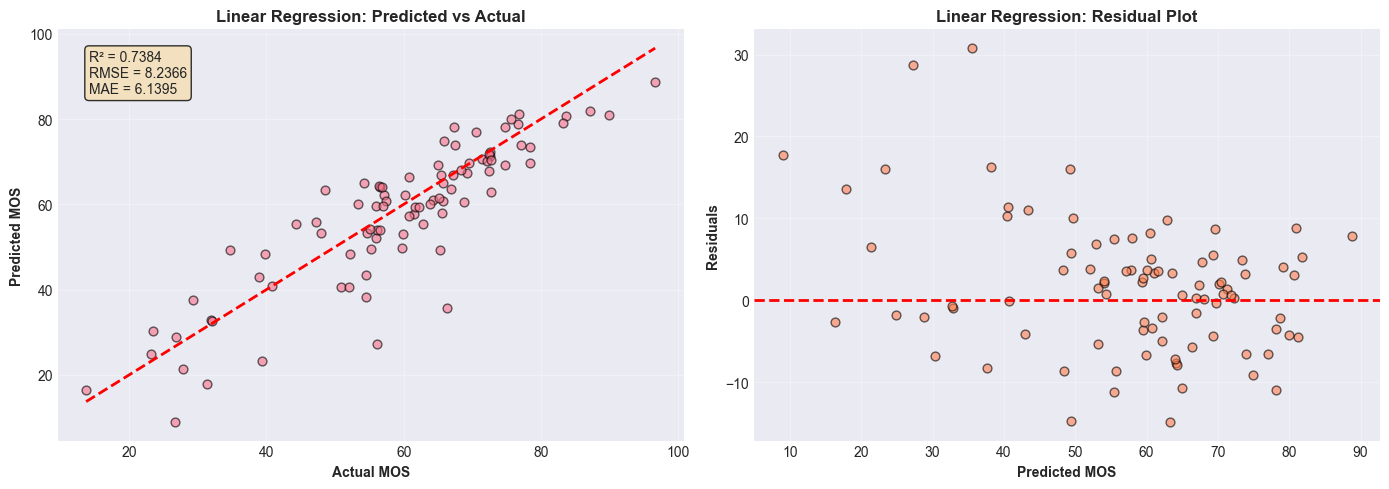

In [126]:
from sklearn.linear_model import LinearRegression

print("="*70)
print("MODEL 1: LINEAR REGRESSION")
print("="*70)

# Initialize model
lr_model = LinearRegression()

# Cross-validation
print(f"\n[1/3] Performing {CV_FOLDS}-Fold Cross-Validation...")
cv_scores_lr = cross_val_score(lr_model, X_train_scaled, y_train, cv=kf, scoring='r2', n_jobs=-1)
print(f"CV R² scores: {[f'{score:.4f}' for score in cv_scores_lr]}")
print(f"Mean CV R²: {cv_scores_lr.mean():.4f} ± {cv_scores_lr.std():.4f}")

# Train model
print("\n[2/3] Training Linear Regression model...")
lr_model.fit(X_train_scaled, y_train)
print("Training complete!")

# Evaluate on test set
print("\n[3/3] Evaluating on test set...")
y_pred_lr = lr_model.predict(X_test_scaled)

# Compute metrics
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
plcc_lr, _ = pearsonr(y_test, y_pred_lr)
srcc_lr, _ = spearmanr(y_test, y_pred_lr)

print("\n" + "="*70)
print("LINEAR REGRESSION - TEST SET RESULTS")
print("="*70)
print(f"MSE:   {mse_lr:.6f}")
print(f"RMSE:  {rmse_lr:.6f}")
print(f"MAE:   {mae_lr:.6f}")
print(f"R²:    {r2_lr:.6f}")
print(f"PLCC:  {plcc_lr:.6f}")
print(f"SRCC:  {srcc_lr:.6f}")
print("="*70)

# Store results
all_model_results.append({
    'Model': 'Linear Regression',
    'MSE': mse_lr,
    'RMSE': rmse_lr,
    'MAE': mae_lr,
    'R²': r2_lr,
    'PLCC': plcc_lr,
    'SRCC': srcc_lr,
    'CV_R²_mean': cv_scores_lr.mean(),
    'CV_R²_std': cv_scores_lr.std()
})

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted vs Actual
axes[0].scatter(y_test, y_pred_lr, alpha=0.6, edgecolors='black', s=40)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual MOS', fontweight='bold')
axes[0].set_ylabel('Predicted MOS', fontweight='bold')
axes[0].set_title('Linear Regression: Predicted vs Actual', fontweight='bold')
axes[0].grid(True, alpha=0.3)
textstr = f'R² = {r2_lr:.4f}\nRMSE = {rmse_lr:.4f}\nMAE = {mae_lr:.4f}'
axes[0].text(0.05, 0.95, textstr, transform=axes[0].transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Residuals
residuals_lr = y_test - y_pred_lr
axes[1].scatter(y_pred_lr, residuals_lr, alpha=0.6, edgecolors='black', s=40, c='coral')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted MOS', fontweight='bold')
axes[1].set_ylabel('Residuals', fontweight='bold')
axes[1].set_title('Linear Regression: Residual Plot', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4.2 Model 2: Decision Tree

Decision Tree is a non-parametric model that learns decision rules from features. It can capture non-linear relationships and provides interpretability through feature importance analysis.

In [127]:
from sklearn.tree import DecisionTreeRegressor

print("="*70)
print("MODEL 2: DECISION TREE")
print("="*70)

# Initialize model (parameters from paper)
dt_model = DecisionTreeRegressor(
    min_samples_split=9,
    random_state=0
)

# Cross-validation
print(f"\n[1/3] Performing {CV_FOLDS}-Fold Cross-Validation...")
cv_scores_dt = cross_val_score(dt_model, X_train_scaled, y_train, cv=kf, scoring='r2', n_jobs=-1)
print(f"CV R² scores: {[f'{score:.4f}' for score in cv_scores_dt]}")
print(f"Mean CV R²: {cv_scores_dt.mean():.4f} ± {cv_scores_dt.std():.4f}")

# Train model
print("\n[2/3] Training Decision Tree model...")
dt_model.fit(X_train_scaled, y_train)
print(f"Tree depth: {dt_model.get_depth()}")
print(f"Number of leaves: {dt_model.get_n_leaves()}")
print("Training complete!")

# Evaluate on test set
print("\n[3/3] Evaluating on test set...")
y_pred_dt = dt_model.predict(X_test_scaled)

# Compute metrics
r2_dt = r2_score(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
plcc_dt, _ = pearsonr(y_test, y_pred_dt)
srcc_dt, _ = spearmanr(y_test, y_pred_dt)

print(f"\nR² Score: {r2_dt:.6f}")
print(f"RMSE: {rmse_dt:.6f}")
print(f"MAE: {mae_dt:.6f}")
print(f"MSE: {mse_dt:.6f}")
print(f"PLCC: {plcc_dt:.6f}")
print(f"SRCC: {srcc_dt:.6f}")

# Calculate accuracy within tolerance
residuals_dt = y_test - y_pred_dt
accuracy_dt = np.mean(np.abs(residuals_dt) <= 0.5) * 100  # Within 0.5 MOS units

print(f"\nAccuracy (±0.5 MOS): {accuracy_dt:.2f}%")
print("="*70)

# Store results
all_model_results.append({
    'Model': 'Decision Tree',
    'R²': r2_dt,
    'RMSE': rmse_dt,
    'MAE': mae_dt,
    'MSE': mse_dt,
    'PLCC': plcc_dt,
    'SRCC': srcc_dt,
    'CV_R²_mean': cv_scores_dt.mean(),
    'CV_R²_std': cv_scores_dt.std(),
    'Accuracy': accuracy_dt
})

# Store predictions
predictions['Decision Tree'] = y_pred_dt

MODEL 2: DECISION TREE

[1/3] Performing 5-Fold Cross-Validation...
CV R² scores: ['0.7245', '0.6722', '0.4042', '0.5554', '0.6403']
Mean CV R²: 0.5993 ± 0.1119

[2/3] Training Decision Tree model...
Tree depth: 17
Number of leaves: 84
Training complete!

[3/3] Evaluating on test set...

R² Score: 0.678281
RMSE: 9.134008
MAE: 7.243750
MSE: 83.430109
PLCC: 0.848966
SRCC: 0.788760

Accuracy (±0.5 MOS): 3.33%


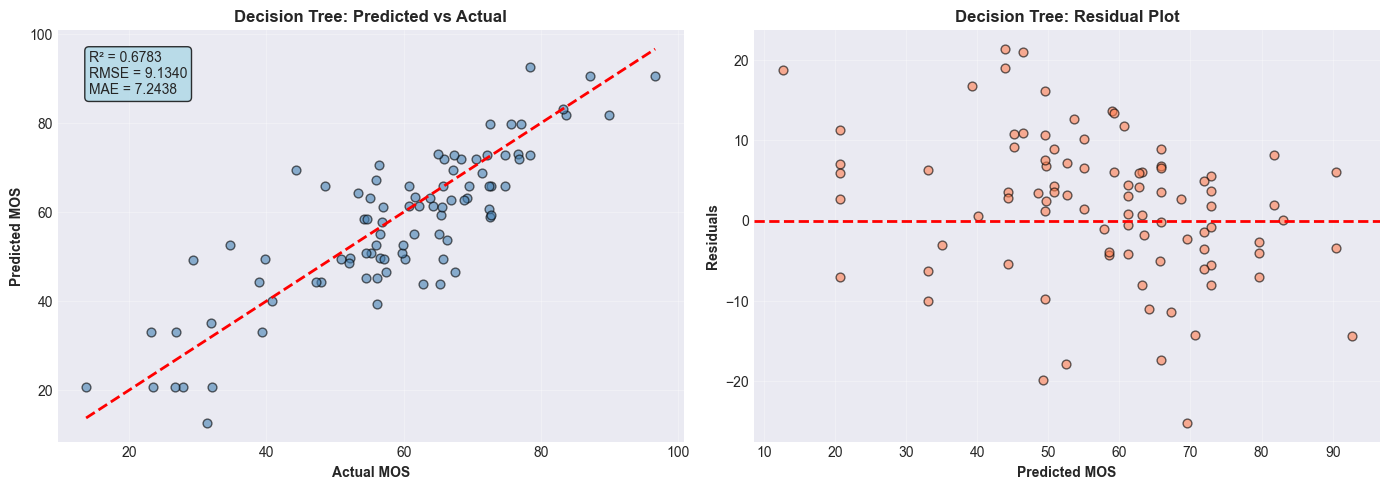

In [128]:
# Visualization for Decision Tree
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted vs Actual
axes[0].scatter(y_test, y_pred_dt, alpha=0.6, edgecolors='black', s=40, c='steelblue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual MOS', fontweight='bold')
axes[0].set_ylabel('Predicted MOS', fontweight='bold')
axes[0].set_title('Decision Tree: Predicted vs Actual', fontweight='bold')
axes[0].grid(True, alpha=0.3)
textstr = f'R² = {r2_dt:.4f}\nRMSE = {rmse_dt:.4f}\nMAE = {mae_dt:.4f}'
axes[0].text(0.05, 0.95, textstr, transform=axes[0].transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Residuals
axes[1].scatter(y_pred_dt, residuals_dt, alpha=0.6, edgecolors='black', s=40, c='coral')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted MOS', fontweight='bold')
axes[1].set_ylabel('Residuals', fontweight='bold')
axes[1].set_title('Decision Tree: Residual Plot', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4.3 Model 3: Random Forest

Random Forest is an ensemble method that combines multiple decision trees to improve prediction accuracy and reduce overfitting. It uses bootstrap aggregating (bagging) to train trees on different subsets of data.

In [129]:
from sklearn.ensemble import RandomForestRegressor

print("="*70)
print("MODEL 3: RANDOM FOREST")
print("="*70)

# Initialize model (parameters from paper)
rf_model = RandomForestRegressor(
    n_estimators=500,
    random_state=0,
    n_jobs=-1
)

# Cross-validation
print(f"\n[1/3] Performing {CV_FOLDS}-Fold Cross-Validation...")
cv_scores_rf = cross_val_score(rf_model, X_train_scaled, y_train, cv=kf, scoring='r2', n_jobs=-1)
print(f"CV R² scores: {[f'{score:.4f}' for score in cv_scores_rf]}")
print(f"Mean CV R²: {cv_scores_rf.mean():.4f} ± {cv_scores_rf.std():.4f}")

# Train model
print("\n[2/3] Training Random Forest model...")
rf_model.fit(X_train_scaled, y_train)
print(f"Number of trees: {rf_model.n_estimators}")
print("Training complete!")

# Evaluate on test set
print("\n[3/3] Evaluating on test set...")
y_pred_rf = rf_model.predict(X_test_scaled)

# Compute metrics
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
plcc_rf, _ = pearsonr(y_test, y_pred_rf)
srcc_rf, _ = spearmanr(y_test, y_pred_rf)

print(f"\nR² Score: {r2_rf:.6f}")
print(f"RMSE: {rmse_rf:.6f}")
print(f"MAE: {mae_rf:.6f}")
print(f"MSE: {mse_rf:.6f}")
print(f"PLCC: {plcc_rf:.6f}")
print(f"SRCC: {srcc_rf:.6f}")

# Calculate accuracy within tolerance
residuals_rf = y_test - y_pred_rf
accuracy_rf = np.mean(np.abs(residuals_rf) <= 0.5) * 100  # Within 0.5 MOS units

print(f"\nAccuracy (±0.5 MOS): {accuracy_rf:.2f}%")
print("="*70)

# Store results
all_model_results.append({
    'Model': 'Random Forest',
    'R²': r2_rf,
    'RMSE': rmse_rf,
    'MAE': mae_rf,
    'MSE': mse_rf,
    'PLCC': plcc_rf,
    'SRCC': srcc_rf,
    'CV_R²_mean': cv_scores_rf.mean(),
    'CV_R²_std': cv_scores_rf.std(),
    'Accuracy': accuracy_rf
})

# Store predictions
predictions['Random Forest'] = y_pred_rf

MODEL 3: RANDOM FOREST

[1/3] Performing 5-Fold Cross-Validation...
CV R² scores: ['0.7840', '0.8511', '0.7747', '0.7174', '0.7616']
Mean CV R²: 0.7778 ± 0.0432

[2/3] Training Random Forest model...
Number of trees: 500
Training complete!

[3/3] Evaluating on test set...

R² Score: 0.846731
RMSE: 6.304488
MAE: 4.832529
MSE: 39.746573
PLCC: 0.922879
SRCC: 0.925159

Accuracy (±0.5 MOS): 10.00%


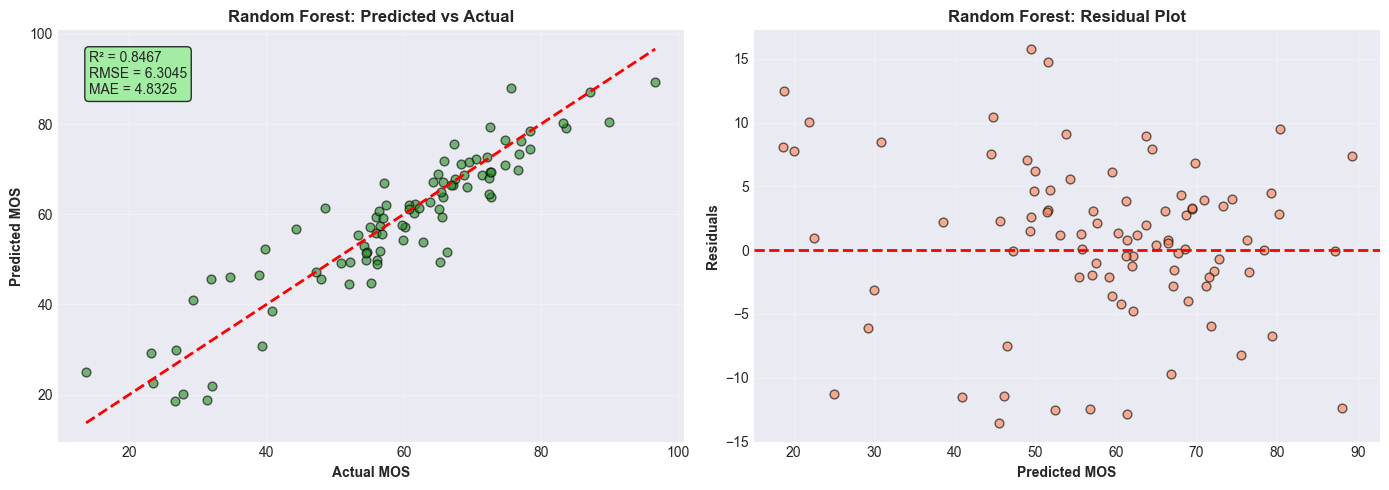

In [130]:
# Visualization for Random Forest
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted vs Actual
axes[0].scatter(y_test, y_pred_rf, alpha=0.6, edgecolors='black', s=40, c='forestgreen')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual MOS', fontweight='bold')
axes[0].set_ylabel('Predicted MOS', fontweight='bold')
axes[0].set_title('Random Forest: Predicted vs Actual', fontweight='bold')
axes[0].grid(True, alpha=0.3)
textstr = f'R² = {r2_rf:.4f}\nRMSE = {rmse_rf:.4f}\nMAE = {mae_rf:.4f}'
axes[0].text(0.05, 0.95, textstr, transform=axes[0].transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# Residuals
axes[1].scatter(y_pred_rf, residuals_rf, alpha=0.6, edgecolors='black', s=40, c='coral')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted MOS', fontweight='bold')
axes[1].set_ylabel('Residuals', fontweight='bold')
axes[1].set_title('Random Forest: Residual Plot', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4.4 Model 4: Gradient Boosting

Gradient Boosting builds an ensemble of trees sequentially, where each tree corrects the errors of the previous ones. It's known for high predictive accuracy and robustness.

In [131]:
from sklearn.ensemble import GradientBoostingRegressor

print("="*70)
print("MODEL 4: GRADIENT BOOSTING")
print("="*70)

# Initialize model (parameters from paper)
gb_model = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.01,
    random_state=0
)

# Cross-validation
print(f"\n[1/3] Performing {CV_FOLDS}-Fold Cross-Validation...")
cv_scores_gb = cross_val_score(gb_model, X_train_scaled, y_train, cv=kf, scoring='r2', n_jobs=-1)
print(f"CV R² scores: {[f'{score:.4f}' for score in cv_scores_gb]}")
print(f"Mean CV R²: {cv_scores_gb.mean():.4f} ± {cv_scores_gb.std():.4f}")

# Train model
print("\n[2/3] Training Gradient Boosting model...")
gb_model.fit(X_train_scaled, y_train)
print(f"Number of boosting stages: {gb_model.n_estimators}")
print("Training complete!")

# Evaluate on test set
print("\n[3/3] Evaluating on test set...")
y_pred_gb = gb_model.predict(X_test_scaled)

# Compute metrics
r2_gb = r2_score(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
plcc_gb, _ = pearsonr(y_test, y_pred_gb)
srcc_gb, _ = spearmanr(y_test, y_pred_gb)

print(f"\nR² Score: {r2_gb:.6f}")
print(f"RMSE: {rmse_gb:.6f}")
print(f"MAE: {mae_gb:.6f}")
print(f"MSE: {mse_gb:.6f}")
print(f"PLCC: {plcc_gb:.6f}")
print(f"SRCC: {srcc_gb:.6f}")

# Calculate accuracy within tolerance
residuals_gb = y_test - y_pred_gb
accuracy_gb = np.mean(np.abs(residuals_gb) <= 0.5) * 100  # Within 0.5 MOS units

print(f"\nAccuracy (±0.5 MOS): {accuracy_gb:.2f}%")
print("="*70)

# Store results
all_model_results.append({
    'Model': 'Gradient Boosting',
    'R²': r2_gb,
    'RMSE': rmse_gb,
    'MAE': mae_gb,
    'MSE': mse_gb,
    'PLCC': plcc_gb,
    'SRCC': srcc_gb,
    'CV_R²_mean': cv_scores_gb.mean(),
    'CV_R²_std': cv_scores_gb.std(),
    'Accuracy': accuracy_gb
})

# Store predictions
predictions['Gradient Boosting'] = y_pred_gb

MODEL 4: GRADIENT BOOSTING

[1/3] Performing 5-Fold Cross-Validation...
CV R² scores: ['0.7856', '0.8552', '0.7839', '0.7092', '0.7754']
Mean CV R²: 0.7819 ± 0.0463

[2/3] Training Gradient Boosting model...
Number of boosting stages: 500
Training complete!

[3/3] Evaluating on test set...

R² Score: 0.859752
RMSE: 6.030742
MAE: 4.641118
MSE: 36.369847
PLCC: 0.929651
SRCC: 0.928123

Accuracy (±0.5 MOS): 8.89%


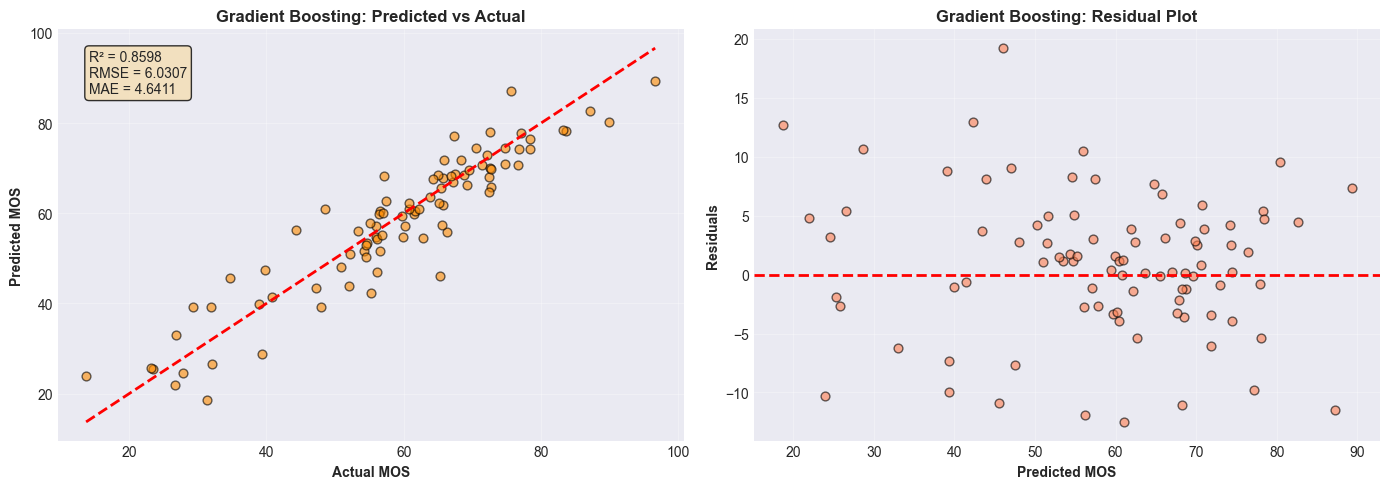

In [132]:
# Visualization for Gradient Boosting
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted vs Actual
axes[0].scatter(y_test, y_pred_gb, alpha=0.6, edgecolors='black', s=40, c='darkorange')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual MOS', fontweight='bold')
axes[0].set_ylabel('Predicted MOS', fontweight='bold')
axes[0].set_title('Gradient Boosting: Predicted vs Actual', fontweight='bold')
axes[0].grid(True, alpha=0.3)
textstr = f'R² = {r2_gb:.4f}\nRMSE = {rmse_gb:.4f}\nMAE = {mae_gb:.4f}'
axes[0].text(0.05, 0.95, textstr, transform=axes[0].transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Residuals
axes[1].scatter(y_pred_gb, residuals_gb, alpha=0.6, edgecolors='black', s=40, c='coral')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted MOS', fontweight='bold')
axes[1].set_ylabel('Residuals', fontweight='bold')
axes[1].set_title('Gradient Boosting: Residual Plot', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4.5 Model 5: Support Vector Regression (SVR)

SVR uses kernel functions to map data into higher-dimensional space where linear regression can be performed. The RBF kernel captures non-linear patterns in the data.

In [133]:
from sklearn.svm import SVR

print("="*70)
print("MODEL 5: SUPPORT VECTOR REGRESSION (SVR)")
print("="*70)

# Initialize model (parameters from paper)
svr_model = SVR(
    kernel='rbf',
    C=10
)

# Cross-validation
print(f"\n[1/3] Performing {CV_FOLDS}-Fold Cross-Validation...")
cv_scores_svr = cross_val_score(svr_model, X_train_scaled, y_train, cv=kf, scoring='r2', n_jobs=-1)
print(f"CV R² scores: {[f'{score:.4f}' for score in cv_scores_svr]}")
print(f"Mean CV R²: {cv_scores_svr.mean():.4f} ± {cv_scores_svr.std():.4f}")

# Train model
print("\n[2/3] Training SVR model...")
svr_model.fit(X_train_scaled, y_train)
print(f"Kernel: {svr_model.kernel}")
print(f"Support vectors: {len(svr_model.support_)}")
print("Training complete!")

# Evaluate on test set
print("\n[3/3] Evaluating on test set...")
y_pred_svr = svr_model.predict(X_test_scaled)

# Compute metrics
r2_svr = r2_score(y_test, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
plcc_svr, _ = pearsonr(y_test, y_pred_svr)
srcc_svr, _ = spearmanr(y_test, y_pred_svr)

print(f"\nR² Score: {r2_svr:.6f}")
print(f"RMSE: {rmse_svr:.6f}")
print(f"MAE: {mae_svr:.6f}")
print(f"MSE: {mse_svr:.6f}")
print(f"PLCC: {plcc_svr:.6f}")
print(f"SRCC: {srcc_svr:.6f}")

# Calculate accuracy within tolerance
residuals_svr = y_test - y_pred_svr
accuracy_svr = np.mean(np.abs(residuals_svr) <= 0.5) * 100  # Within 0.5 MOS units

print(f"\nAccuracy (±0.5 MOS): {accuracy_svr:.2f}%")
print("="*70)

# Store results
all_model_results.append({
    'Model': 'SVR',
    'R²': r2_svr,
    'RMSE': rmse_svr,
    'MAE': mae_svr,
    'MSE': mse_svr,
    'PLCC': plcc_svr,
    'SRCC': srcc_svr,
    'CV_R²_mean': cv_scores_svr.mean(),
    'CV_R²_std': cv_scores_svr.std(),
    'Accuracy': accuracy_svr
})

# Store predictions
predictions['SVR'] = y_pred_svr

MODEL 5: SUPPORT VECTOR REGRESSION (SVR)

[1/3] Performing 5-Fold Cross-Validation...
CV R² scores: ['0.7549', '0.7962', '0.7030', '0.6011', '0.6660']
Mean CV R²: 0.7042 ± 0.0680

[2/3] Training SVR model...
Kernel: rbf
Support vectors: 358
Training complete!

[3/3] Evaluating on test set...

R² Score: 0.832032
RMSE: 6.599888
MAE: 4.916010
MSE: 43.558527
PLCC: 0.913162
SRCC: 0.914179

Accuracy (±0.5 MOS): 13.33%


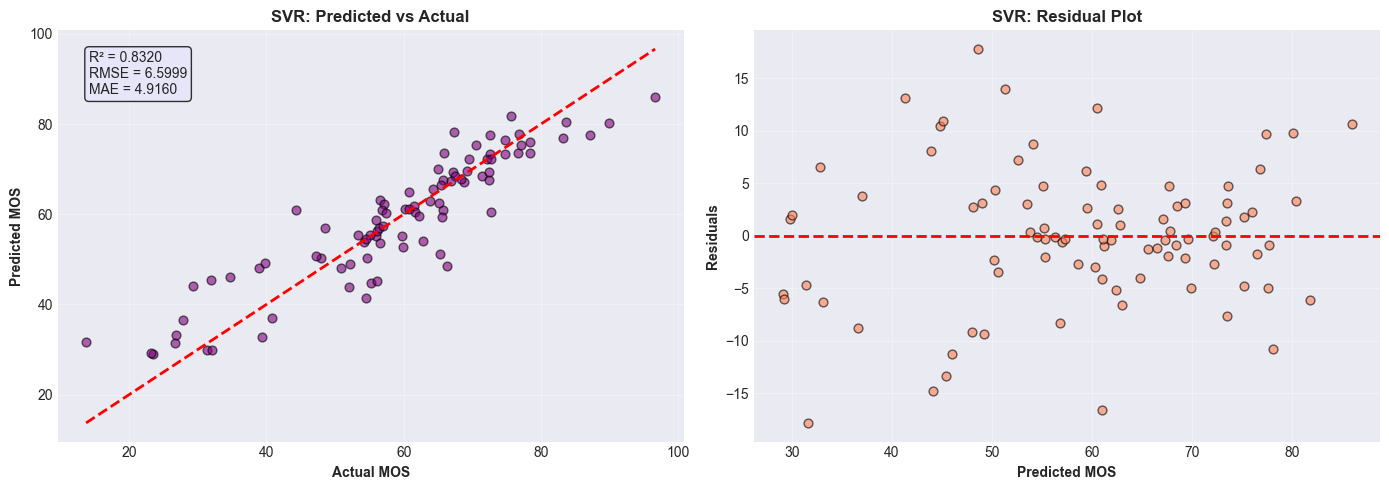

In [134]:
# Visualization for SVR
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted vs Actual
axes[0].scatter(y_test, y_pred_svr, alpha=0.6, edgecolors='black', s=40, c='purple')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual MOS', fontweight='bold')
axes[0].set_ylabel('Predicted MOS', fontweight='bold')
axes[0].set_title('SVR: Predicted vs Actual', fontweight='bold')
axes[0].grid(True, alpha=0.3)
textstr = f'R² = {r2_svr:.4f}\nRMSE = {rmse_svr:.4f}\nMAE = {mae_svr:.4f}'
axes[0].text(0.05, 0.95, textstr, transform=axes[0].transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lavender', alpha=0.8))

# Residuals
axes[1].scatter(y_pred_svr, residuals_svr, alpha=0.6, edgecolors='black', s=40, c='coral')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted MOS', fontweight='bold')
axes[1].set_ylabel('Residuals', fontweight='bold')
axes[1].set_title('SVR: Residual Plot', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4.6 Model 6: K-Nearest Neighbors (KNN)

KNN is an instance-based learning algorithm that predicts QoE based on the k most similar training samples. It's non-parametric and can capture local patterns in the data.

In [135]:
from sklearn.neighbors import KNeighborsRegressor

print("="*70)
print("MODEL 6: K-NEAREST NEIGHBORS (KNN)")
print("="*70)

# Initialize model (parameters from paper)
knn_model = KNeighborsRegressor(
    n_neighbors=10,
    weights='uniform',
    n_jobs=-1
)

# Cross-validation
print(f"\n[1/3] Performing {CV_FOLDS}-Fold Cross-Validation...")
cv_scores_knn = cross_val_score(knn_model, X_train_scaled, y_train, cv=kf, scoring='r2', n_jobs=-1)
print(f"CV R² scores: {[f'{score:.4f}' for score in cv_scores_knn]}")
print(f"Mean CV R²: {cv_scores_knn.mean():.4f} ± {cv_scores_knn.std():.4f}")

# Train model
print("\n[2/3] Training KNN model...")
knn_model.fit(X_train_scaled, y_train)
print(f"Number of neighbors (k): {knn_model.n_neighbors}")
print(f"Training samples: {knn_model.n_samples_fit_}")
print("Training complete!")

# Evaluate on test set
print("\n[3/3] Evaluating on test set...")
y_pred_knn = knn_model.predict(X_test_scaled)

# Compute metrics
r2_knn = r2_score(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
plcc_knn, _ = pearsonr(y_test, y_pred_knn)
srcc_knn, _ = spearmanr(y_test, y_pred_knn)

print(f"\nR² Score: {r2_knn:.6f}")
print(f"RMSE: {rmse_knn:.6f}")
print(f"MAE: {mae_knn:.6f}")
print(f"MSE: {mse_knn:.6f}")
print(f"PLCC: {plcc_knn:.6f}")
print(f"SRCC: {srcc_knn:.6f}")

# Calculate accuracy within tolerance
residuals_knn = y_test - y_pred_knn
accuracy_knn = np.mean(np.abs(residuals_knn) <= 0.5) * 100  # Within 0.5 MOS units

print(f"\nAccuracy (±0.5 MOS): {accuracy_knn:.2f}%")
print("="*70)

# Store results
all_model_results.append({
    'Model': 'KNN',
    'R²': r2_knn,
    'RMSE': rmse_knn,
    'MAE': mae_knn,
    'MSE': mse_knn,
    'PLCC': plcc_knn,
    'SRCC': srcc_knn,
    'CV_R²_mean': cv_scores_knn.mean(),
    'CV_R²_std': cv_scores_knn.std(),
    'Accuracy': accuracy_knn
})

# Store predictions
predictions['KNN'] = y_pred_knn

MODEL 6: K-NEAREST NEIGHBORS (KNN)

[1/3] Performing 5-Fold Cross-Validation...
CV R² scores: ['0.6637', '0.6578', '0.6324', '0.6459', '0.6742']
Mean CV R²: 0.6548 ± 0.0145

[2/3] Training KNN model...
Number of neighbors (k): 10
Training samples: 360
Training complete!

[3/3] Evaluating on test set...

R² Score: 0.697419
RMSE: 8.858170
MAE: 6.806756
MSE: 78.467175
PLCC: 0.869397
SRCC: 0.858817

Accuracy (±0.5 MOS): 4.44%


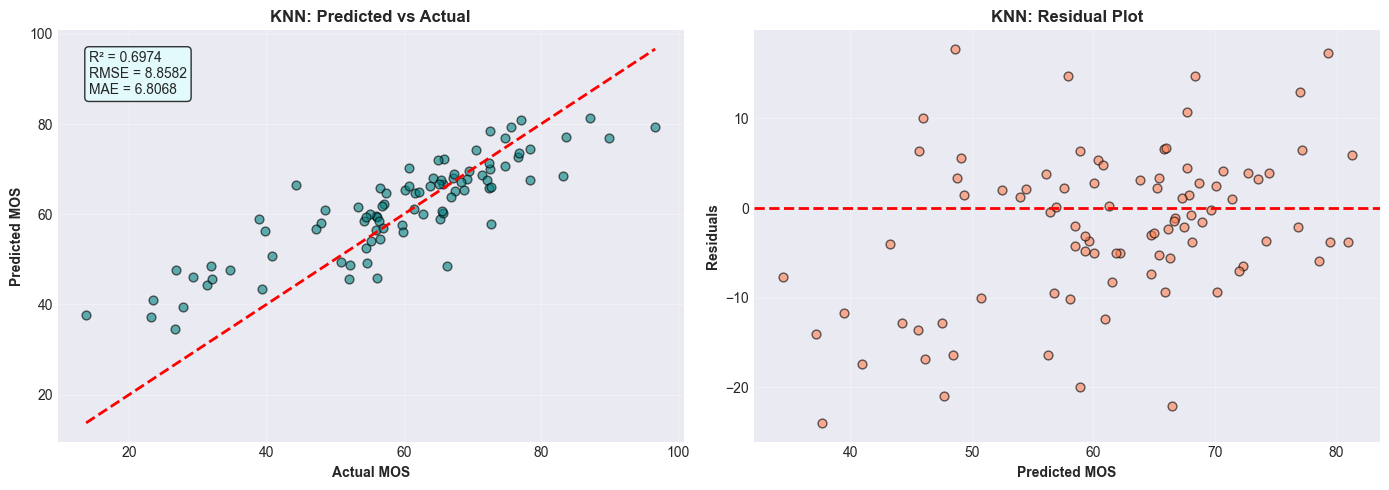

In [136]:
# Visualization for KNN
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted vs Actual
axes[0].scatter(y_test, y_pred_knn, alpha=0.6, edgecolors='black', s=40, c='teal')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual MOS', fontweight='bold')
axes[0].set_ylabel('Predicted MOS', fontweight='bold')
axes[0].set_title('KNN: Predicted vs Actual', fontweight='bold')
axes[0].grid(True, alpha=0.3)
textstr = f'R² = {r2_knn:.4f}\nRMSE = {rmse_knn:.4f}\nMAE = {mae_knn:.4f}'
axes[0].text(0.05, 0.95, textstr, transform=axes[0].transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))

# Residuals
axes[1].scatter(y_pred_knn, residuals_knn, alpha=0.6, edgecolors='black', s=40, c='coral')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted MOS', fontweight='bold')
axes[1].set_ylabel('Residuals', fontweight='bold')
axes[1].set_title('KNN: Residual Plot', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4.7 Model 7: Multi-Layer Perceptron (MLP)

MLP is a feed-forward artificial neural network that can learn complex non-linear relationships through multiple hidden layers. It's particularly effective for high-dimensional data.

In [137]:
from sklearn.neural_network import MLPRegressor

print("="*70)
print("MODEL 7: MULTI-LAYER PERCEPTRON (MLP)")
print("="*70)

# Initialize model (parameters from paper)
mlp_model = MLPRegressor(
    hidden_layer_sizes=(20,),
    activation='relu',
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=0,
    early_stopping=True
)

# Cross-validation
print(f"\n[1/3] Performing {CV_FOLDS}-Fold Cross-Validation...")
cv_scores_mlp = cross_val_score(mlp_model, X_train_scaled, y_train, cv=kf, scoring='r2', n_jobs=-1)
print(f"CV R² scores: {[f'{score:.4f}' for score in cv_scores_mlp]}")
print(f"Mean CV R²: {cv_scores_mlp.mean():.4f} ± {cv_scores_mlp.std():.4f}")

# Train model
print("\n[2/3] Training MLP model...")
mlp_model.fit(X_train_scaled, y_train)
print(f"Hidden layers: {mlp_model.hidden_layer_sizes}")
print(f"Number of iterations: {mlp_model.n_iter_}")
print(f"Number of layers: {mlp_model.n_layers_}")
print("Training complete!")

# Evaluate on test set
print("\n[3/3] Evaluating on test set...")
y_pred_mlp = mlp_model.predict(X_test_scaled)

# Compute metrics
r2_mlp = r2_score(y_test, y_pred_mlp)
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
plcc_mlp, _ = pearsonr(y_test, y_pred_mlp)
srcc_mlp, _ = spearmanr(y_test, y_pred_mlp)

print(f"\nR² Score: {r2_mlp:.6f}")
print(f"RMSE: {rmse_mlp:.6f}")
print(f"MAE: {mae_mlp:.6f}")
print(f"MSE: {mse_mlp:.6f}")
print(f"PLCC: {plcc_mlp:.6f}")
print(f"SRCC: {srcc_mlp:.6f}")

# Calculate accuracy within tolerance
residuals_mlp = y_test - y_pred_mlp
accuracy_mlp = np.mean(np.abs(residuals_mlp) <= 0.5) * 100  # Within 0.5 MOS units

print(f"\nAccuracy (±0.5 MOS): {accuracy_mlp:.2f}%")
print("="*70)

# Store results
all_model_results.append({
    'Model': 'MLP',
    'R²': r2_mlp,
    'RMSE': rmse_mlp,
    'MAE': mae_mlp,
    'MSE': mse_mlp,
    'PLCC': plcc_mlp,
    'SRCC': srcc_mlp,
    'CV_R²_mean': cv_scores_mlp.mean(),
    'CV_R²_std': cv_scores_mlp.std(),
    'Accuracy': accuracy_mlp
})

# Store predictions
predictions['MLP'] = y_pred_mlp

MODEL 7: MULTI-LAYER PERCEPTRON (MLP)

[1/3] Performing 5-Fold Cross-Validation...


CV R² scores: ['0.6344', '0.4346', '-0.0047', '-0.4072', '0.3843']
Mean CV R²: 0.2083 ± 0.3709

[2/3] Training MLP model...
Hidden layers: (20,)
Number of iterations: 995
Number of layers: 3
Training complete!

[3/3] Evaluating on test set...

R² Score: 0.613987
RMSE: 10.005154
MAE: 8.041151
MSE: 100.103110
PLCC: 0.820257
SRCC: 0.759970

Accuracy (±0.5 MOS): 4.44%


# 5 Comprehensive Model Comparison

Aggregate and compare the performance of all 7 models across all evaluation metrics.

In [138]:
# Create comprehensive results dataframe
results_df = pd.DataFrame(all_model_results)
results_df = results_df.sort_values(by='RMSE')

print("="*90)
print("COMPREHENSIVE MODEL COMPARISON - ALL 7 MODELS")
print("="*90)
print("\nSorted by RMSE (lower is better):\n")
print(results_df.to_string(index=False))
print("\n" + "="*90)

# Save results
results_df.to_csv(r"data\all_models_comparison.csv", index=False)
print("\nResults saved to: data\\all_models_comparison.csv")

# Identify best model for each metric
print("\n" + "="*90)
print("BEST MODEL FOR EACH METRIC")
print("="*90)

metrics_to_compare = ['RMSE', 'MAE', 'MSE', 'R²', 'PLCC', 'SRCC']
for metric in metrics_to_compare:
    if metric in ['RMSE', 'MAE', 'MSE']:
        # Lower is better
        best_idx = results_df[metric].idxmin()
        comparison = 'lowest'
    else:
        # Higher is better
        best_idx = results_df[metric].idxmax()
        comparison = 'highest'
    
    best_model = results_df.loc[best_idx, 'Model']
    best_value = results_df.loc[best_idx, metric]
    print(f"{metric:6s} ({comparison:7s}): {best_model:20s} = {best_value:.6f}")

print("="*90)

COMPREHENSIVE MODEL COMPARISON - ALL 7 MODELS

Sorted by RMSE (lower is better):

            Model        MSE      RMSE      MAE       R²     PLCC     SRCC  CV_R²_mean  CV_R²_std  Accuracy
Gradient Boosting  36.369847  6.030742 4.641118 0.859752 0.929651 0.928123    0.781880   0.046283  8.888889
    Random Forest  39.746573  6.304488 4.832529 0.846731 0.922879 0.925159    0.777775   0.043200 10.000000
              SVR  43.558527  6.599888 4.916010 0.832032 0.913162 0.914179    0.704245   0.068012 13.333333
Linear Regression  67.841468  8.236593 6.139451 0.738393 0.880796 0.877252    0.288254   0.833294       NaN
              KNN  78.467175  8.858170 6.806756 0.697419 0.869397 0.858817    0.654817   0.014458  4.444444
    Decision Tree  83.430109  9.134008 7.243750 0.678281 0.848966 0.788760    0.599336   0.111948  3.333333
              MLP 100.103110 10.005154 8.041151 0.613987 0.820257 0.759970    0.208269   0.370946  4.444444


Results saved to: data\all_models_comparison.csv

BE

## 5.1 Visual Performance Comparison

Comprehensive visualization comparing all 7 models across different evaluation metrics.

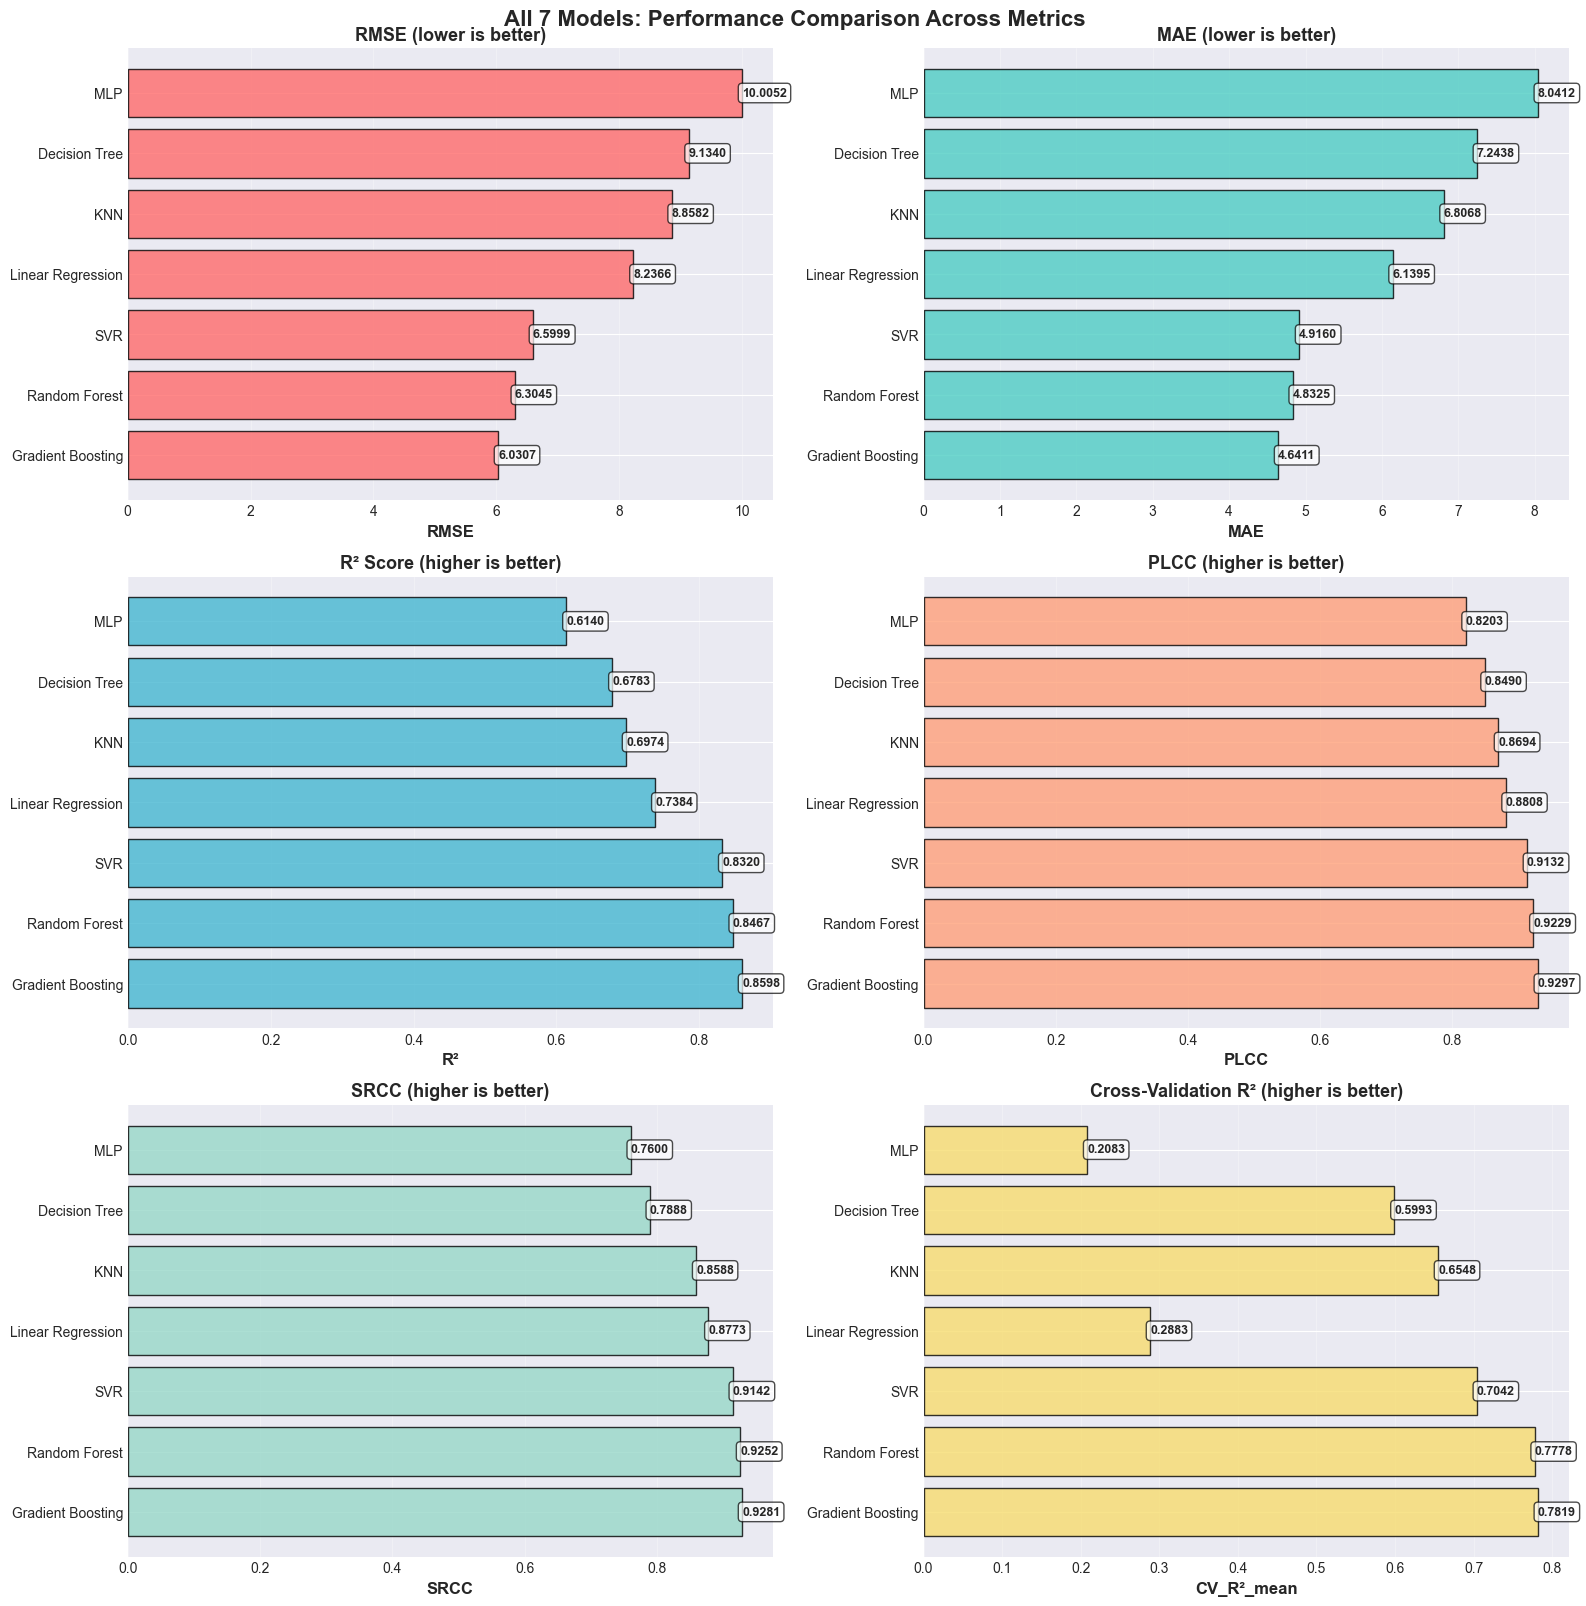

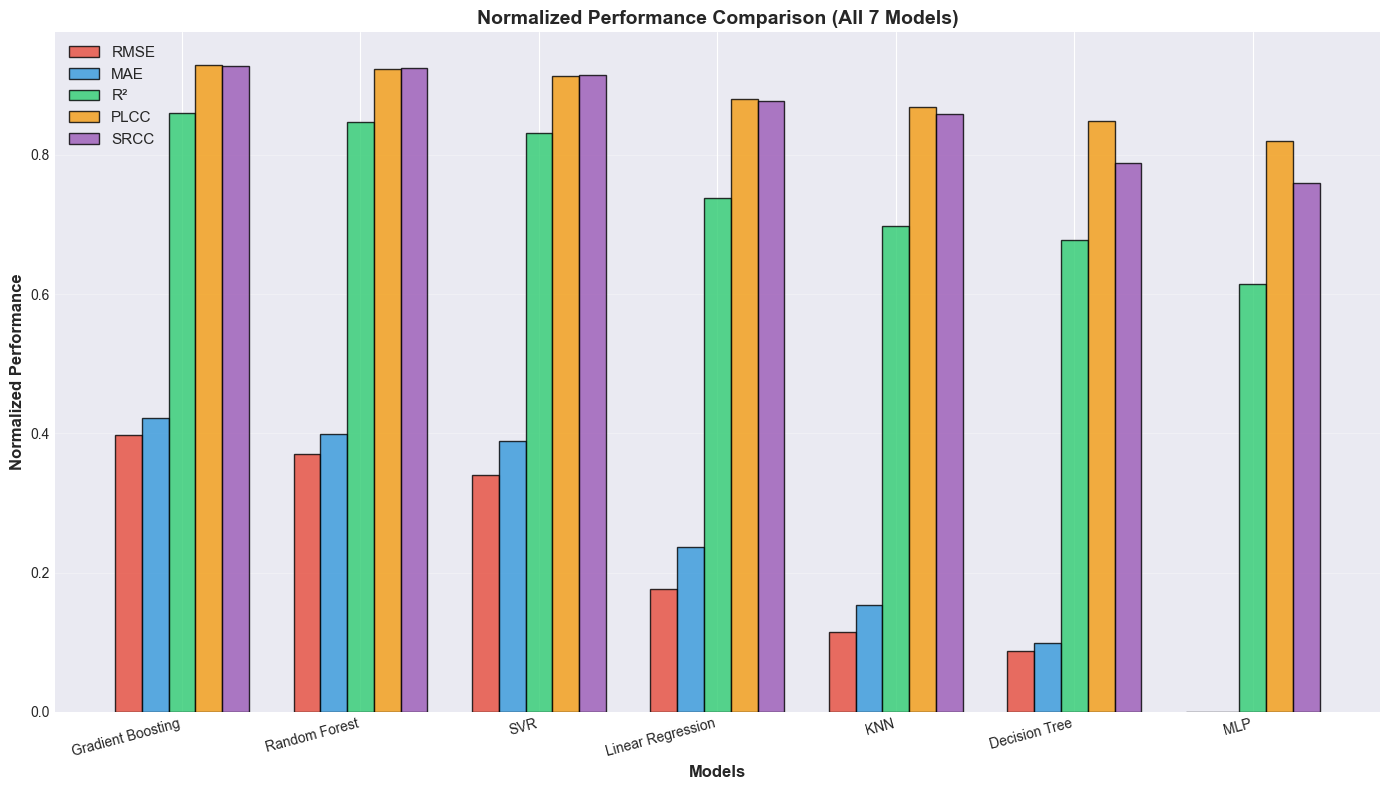

In [139]:
# Comprehensive visualization
fig, axes = plt.subplots(3, 2, figsize=(16, 16))

metrics = ['RMSE', 'MAE', 'R²', 'PLCC', 'SRCC', 'CV_R²_mean']
titles = ['RMSE (lower is better)', 'MAE (lower is better)', 
          'R² Score (higher is better)', 'PLCC (higher is better)',
          'SRCC (higher is better)', 'Cross-Validation R² (higher is better)']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']

for idx, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    values = results_df[metric].values
    models = results_df['Model'].values
    
    bars = ax.barh(models, values, color=color, edgecolor='black', alpha=0.8)
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add value labels on bars
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
                f'{width:.4f}',
                ha='left', va='center', fontsize=9, fontweight='bold', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.suptitle('All 7 Models: Performance Comparison Across Metrics', 
             fontsize=16, fontweight='bold', y=1.001)
plt.show()

# Bar chart comparison for main metrics
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(results_df))
width = 0.15

metrics_to_plot = ['RMSE', 'MAE', 'R²', 'PLCC', 'SRCC']
colors_bar = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']

for i, (metric, color) in enumerate(zip(metrics_to_plot, colors_bar)):
    # Normalize values for better visualization
    values = results_df[metric].values
    if metric in ['RMSE', 'MAE']:
        # For error metrics, lower is better - invert for visualization
        values_normalized = 1 - (values / values.max())
    else:
        # For correlation metrics, higher is better
        values_normalized = values
    
    ax.bar(x + i*width, values_normalized, width, label=metric, 
           color=color, edgecolor='black', alpha=0.8)

ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Normalized Performance', fontsize=12, fontweight='bold')
ax.set_title('Normalized Performance Comparison (All 7 Models)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(results_df['Model'].values, rotation=15, ha='right')
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 5.2 Final Performance Summary Table

Display the comprehensive results table one final time for reference.

In [140]:
# Display final summary
print("="*100)
print(" "*30 + "FINAL PERFORMANCE SUMMARY")
print("="*100)
print("\nAll 7 Models - Complete Evaluation Metrics:")
print(results_df.to_string(index=False))
print("\n" + "="*100)

# Highlight best performers
print("\n" + "="*100)
print("TOP 3 MODELS BY RMSE (Primary Metric)")
print("="*100)
top_3 = results_df.nsmallest(3, 'RMSE')
for idx, (i, row) in enumerate(top_3.iterrows(), 1):
    print(f"\n{idx}. {row['Model']}")
    print(f"   RMSE: {row['RMSE']:.6f} | MAE: {row['MAE']:.6f} | R²: {row['R²']:.6f}")
    print(f"   PLCC: {row['PLCC']:.6f} | SRCC: {row['SRCC']:.6f}")
    print(f"   CV R²: {row['CV_R²_mean']:.4f} ± {row['CV_R²_std']:.4f}")

print("\n" + "="*100)
print("EXPERIMENT COMPLETE - All models trained, evaluated, and saved")
print("="*100)

                              FINAL PERFORMANCE SUMMARY

All 7 Models - Complete Evaluation Metrics:
            Model        MSE      RMSE      MAE       R²     PLCC     SRCC  CV_R²_mean  CV_R²_std  Accuracy
Gradient Boosting  36.369847  6.030742 4.641118 0.859752 0.929651 0.928123    0.781880   0.046283  8.888889
    Random Forest  39.746573  6.304488 4.832529 0.846731 0.922879 0.925159    0.777775   0.043200 10.000000
              SVR  43.558527  6.599888 4.916010 0.832032 0.913162 0.914179    0.704245   0.068012 13.333333
Linear Regression  67.841468  8.236593 6.139451 0.738393 0.880796 0.877252    0.288254   0.833294       NaN
              KNN  78.467175  8.858170 6.806756 0.697419 0.869397 0.858817    0.654817   0.014458  4.444444
    Decision Tree  83.430109  9.134008 7.243750 0.678281 0.848966 0.788760    0.599336   0.111948  3.333333
              MLP 100.103110 10.005154 8.041151 0.613987 0.820257 0.759970    0.208269   0.370946  4.444444


TOP 3 MODELS BY RMSE (Primary Met

## 5.3 Model Performance by MOS Range

Analyze prediction accuracy across different MOS score ranges to identify where the model performs best and where it struggles.

PERFORMANCE BY MOS RANGE (model predictions used: Generic)

Range 13.7-34.5:
  Samples: 10
  RMSE: 11.3036
  MAE:  8.4844
  R²:   -3.6034

Range 34.5-55.2:
  Samples: 18
  RMSE: 7.0916
  MAE:  5.7825
  R²:   -0.2010

Range 55.2-75.9:
  Samples: 52
  RMSE: 8.1043
  MAE:  6.0301
  R²:   -0.8045

Range 75.9-96.6:
  Samples: 10
  RMSE: 6.7794
  MAE:  5.3423
  R²:   -0.1298


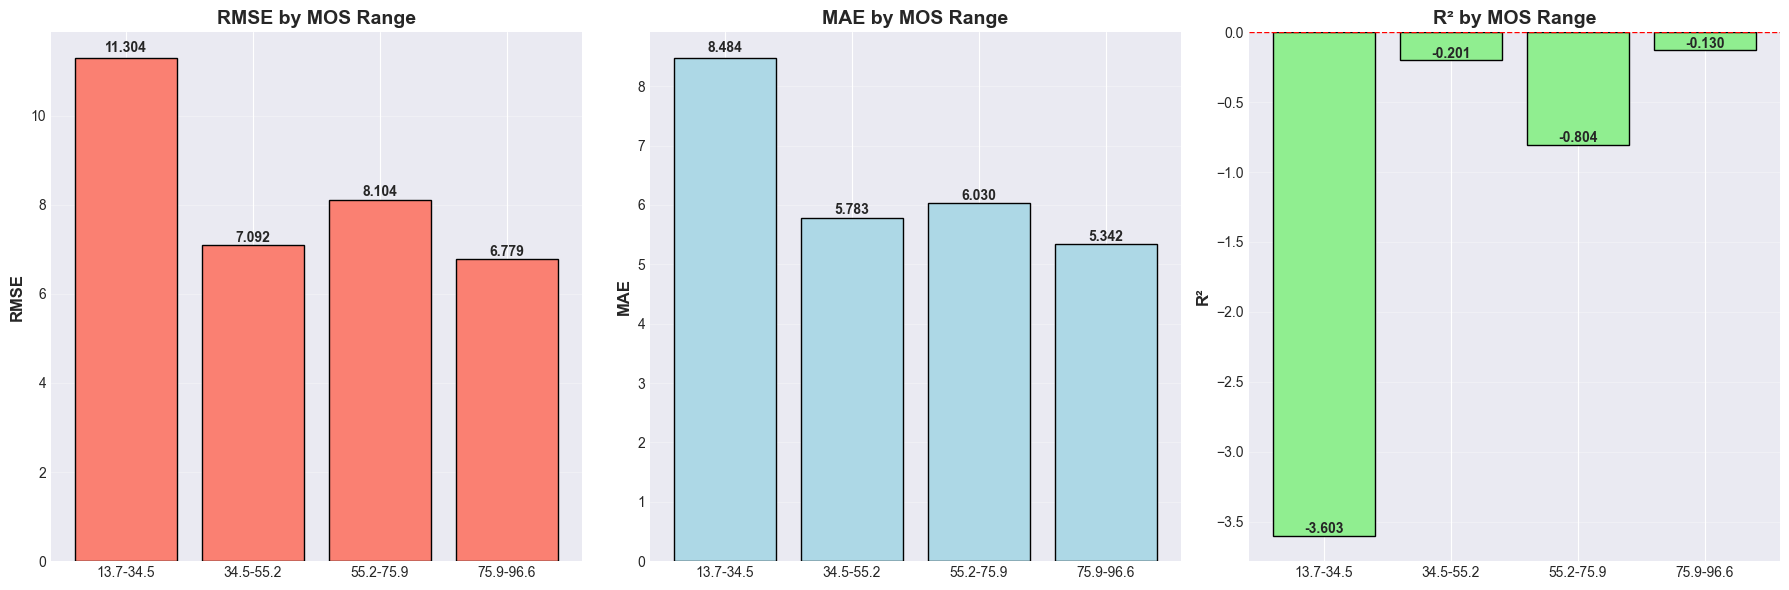

In [141]:
# Performance by MOS range
# Create dynamic ranges based on y_test min/max (4 equal-width bins), and pick a prediction array.
range_metrics = []

# Select prediction array (prefer best model if available)
if 'y_pred' not in globals():
    if 'y_pred_rf' in globals():
        y_pred = y_pred_rf
        model_name = 'Random Forest'
    elif 'y_pred_gb' in globals():
        y_pred = y_pred_gb
        model_name = 'Gradient Boosting'
    elif 'y_pred_mlp' in globals():
        y_pred = y_pred_mlp
        model_name = 'MLP'
    elif 'y_pred_knn' in globals():
        y_pred = y_pred_knn
        model_name = 'KNN'
    elif 'y_pred_lr' in globals():
        y_pred = y_pred_lr
        model_name = 'Linear Regression'
    else:
        raise NameError("No prediction array found. Expected y_pred_rf, y_pred_gb, y_pred_mlp, etc.")
else:
    model_name = 'Generic'

print("="*70)
print(f"PERFORMANCE BY MOS RANGE (model predictions used: {model_name})")
print("="*70)

# Define dynamic bins based on y_test distribution
n_bins = 4
bins = np.linspace(y_test.min(), y_test.max(), n_bins + 1)
range_labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(n_bins)]

for i, label in enumerate(range_labels):
    low = bins[i]
    high = bins[i+1]
    # include right edge for last bin
    if i < n_bins - 1:
        mask = (y_test >= low) & (y_test < high)
    else:
        mask = (y_test >= low) & (y_test <= high)
    
    if mask.sum() > 0:
        y_test_range = y_test[mask]
        y_pred_range = pd.Series(y_pred, index=y_test.index)[mask]
        
        rmse_range = np.sqrt(mean_squared_error(y_test_range, y_pred_range))
        mae_range = mean_absolute_error(y_test_range, y_pred_range)
        r2_range = r2_score(y_test_range, y_pred_range)
        
        range_metrics.append({
            'Range': label,
            'Count': int(mask.sum()),
            'RMSE': float(rmse_range),
            'MAE': float(mae_range),
            'R²': float(r2_range)
        })
        
        print(f"\nRange {label}:")
        print(f"  Samples: {mask.sum()}")
        print(f"  RMSE: {rmse_range:.4f}")
        print(f"  MAE:  {mae_range:.4f}")
        print(f"  R²:   {r2_range:.4f}")

print("="*70)

# Visualize performance by range
if len(range_metrics) == 0:
    print("No samples found for any range. Skipping plots.")
else:
    range_df = pd.DataFrame(range_metrics)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # RMSE by range
    axes[0].bar(range_df['Range'], range_df['RMSE'], color='salmon', edgecolor='black')
    axes[0].set_ylabel('RMSE', fontsize=12, fontweight='bold')
    axes[0].set_title('RMSE by MOS Range', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(range_df['RMSE']):
        axes[0].text(i, v + 0.01 * max(1.0, v), f'{v:.3f}', ha='center', fontsize=10, fontweight='bold')

    # MAE by range
    axes[1].bar(range_df['Range'], range_df['MAE'], color='lightblue', edgecolor='black')
    axes[1].set_ylabel('MAE', fontsize=12, fontweight='bold')
    axes[1].set_title('MAE by MOS Range', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(range_df['MAE']):
        axes[1].text(i, v + 0.01 * max(1.0, v), f'{v:.3f}', ha='center', fontsize=10, fontweight='bold')

    # R² by range
    axes[2].bar(range_df['Range'], range_df['R²'], color='lightgreen', edgecolor='black')
    axes[2].set_ylabel('R²', fontsize=12, fontweight='bold')
    axes[2].set_title('R² by MOS Range', fontsize=14, fontweight='bold')
    axes[2].grid(True, alpha=0.3, axis='y')
    axes[2].axhline(y=0, color='red', linestyle='--', linewidth=1)
    for i, v in enumerate(range_df['R²']):
        axes[2].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

## 5.4 Decision Tree Visualization

Visualize the top levels of the decision tree to understand the decision-making process. Full tree may be too large to display completely.

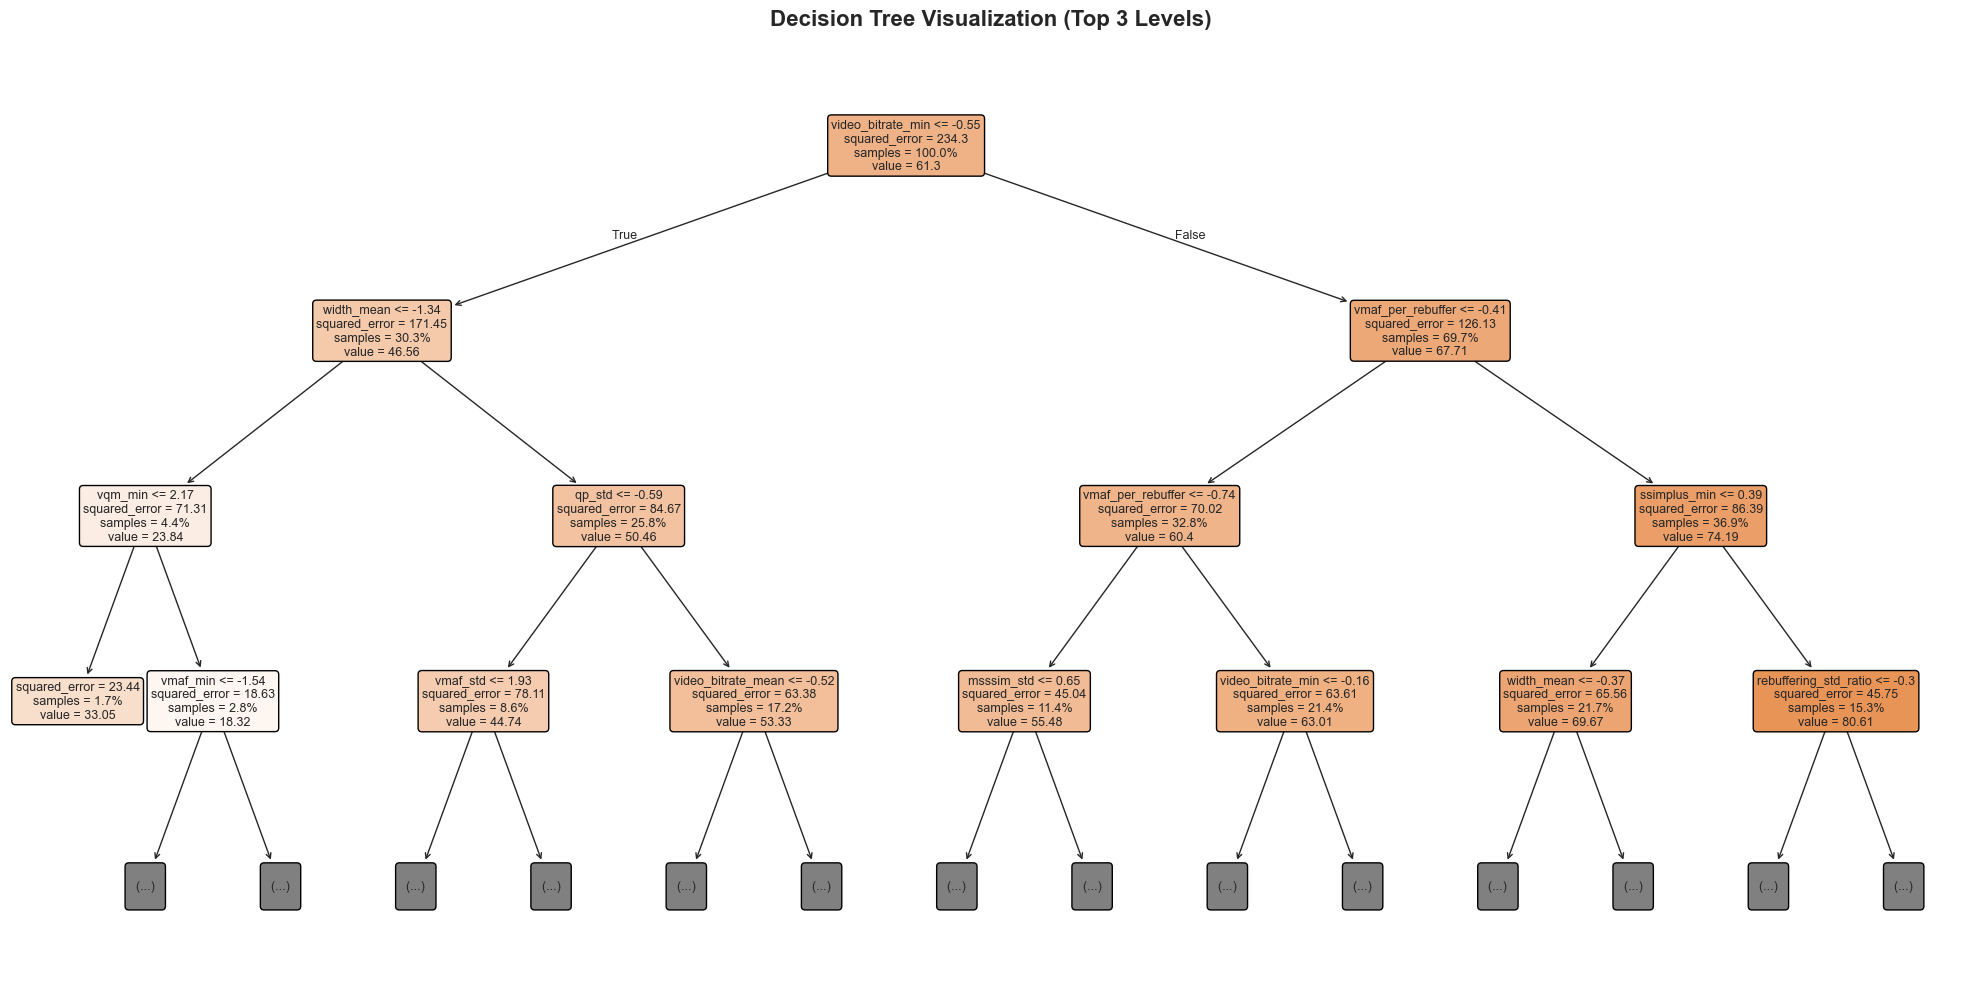


=== Decision Tree Structure ===
Total tree depth: 17
Total number of leaves: 84
Total number of nodes: 167

Note: Visualization shows only the top 3 levels for clarity.


In [142]:
from sklearn.tree import plot_tree

# Visualize decision tree (limited depth for clarity)
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(
    dt_model,
    max_depth=3,  # Show only top 3 levels for clarity
    filled=True,
    feature_names=X.columns,
    fontsize=9,
    rounded=True,
    proportion=True,
    precision=2,
    ax=ax
)
ax.set_title('Decision Tree Visualization (Top 3 Levels)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n=== Decision Tree Structure ===")
print(f"Total tree depth: {dt_model.get_depth()}")
print(f"Total number of leaves: {dt_model.get_n_leaves()}")
print(f"Total number of nodes: {dt_model.tree_.node_count}")
print("\nNote: Visualization shows only the top 3 levels for clarity.")

## 5.5 Feature Importance Analysis

Identify which features contribute most to QoE prediction. This provides insights into the key factors affecting user-perceived video quality.

TOP 20 MOST IMPORTANT FEATURES
 1. video_bitrate_min                        0.429833 (42.98%)
 2. vmaf_per_rebuffer                        0.170698 (17.07%)
 3. width_mean                               0.132945 (13.29%)
 4. ssimplus_min                             0.048722 (4.87%)
 5. rebuffering_std_ratio                    0.027120 (2.71%)
 6. qp_std                                   0.021145 (2.11%)
 7. vqm_min                                  0.015915 (1.59%)
 8. video_bitrate_mean                       0.014858 (1.49%)
 9. index                                    0.014098 (1.41%)
10. vmaf_std                                 0.012584 (1.26%)
11. qp_min                                   0.012279 (1.23%)
12. ssim_per_rebuffer                        0.010999 (1.10%)
13. video_bitrate_max                        0.010355 (1.04%)
14. msssim_std                               0.007311 (0.73%)
15. ssim_x_vmaf                              0.006900 (0.69%)
16. ssimplus_mean                   

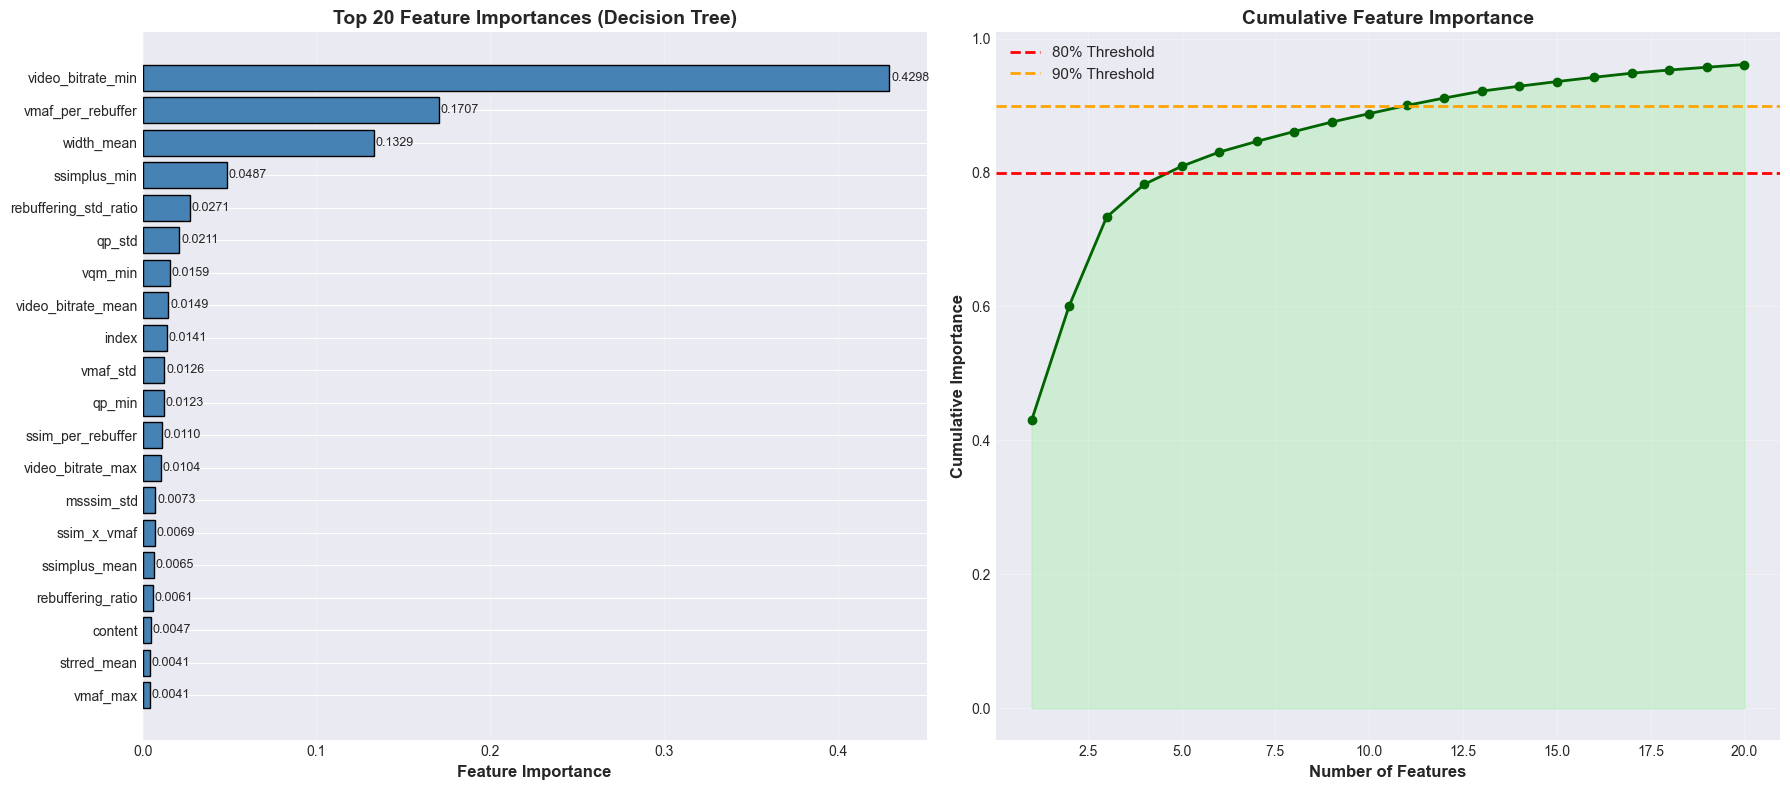


Features needed to capture 80% of importance: 5
Features needed to capture 90% of importance: 11


In [143]:
# Feature importance analysis
importances = dt_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Get top N features
top_n = min(20, len(indices))
top_indices = indices[:top_n]
top_features = X.columns[top_indices]
top_importances = importances[top_indices]

print("="*70)
print("TOP 20 MOST IMPORTANT FEATURES")
print("="*70)
for i, (feat, imp) in enumerate(zip(top_features, top_importances), 1):
    print(f"{i:2d}. {feat:40s} {imp:.6f} ({imp*100:.2f}%)")
print("="*70)

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Bar chart
axes[0].barh(range(top_n), top_importances, color='steelblue', edgecolor='black')
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(top_features, fontsize=10)
axes[0].set_xlabel('Feature Importance', fontsize=12, fontweight='bold')
axes[0].set_title('Top 20 Feature Importances (Decision Tree)', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Add importance values on bars
for i, v in enumerate(top_importances):
    axes[0].text(v + 0.001, i, f'{v:.4f}', va='center', fontsize=9)

# Cumulative importance
cumulative_importance = np.cumsum(top_importances)
axes[1].plot(range(1, top_n + 1), cumulative_importance, marker='o', 
             linewidth=2, markersize=6, color='darkgreen')
axes[1].fill_between(range(1, top_n + 1), cumulative_importance, alpha=0.3, color='lightgreen')
axes[1].set_xlabel('Number of Features', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cumulative Importance', fontsize=12, fontweight='bold')
axes[1].set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0.8, color='r', linestyle='--', label='80% Threshold', linewidth=2)
axes[1].axhline(y=0.9, color='orange', linestyle='--', label='90% Threshold', linewidth=2)
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.show()

# Calculate how many features capture 80% and 90% of importance
n_features_80 = np.where(cumulative_importance >= 0.8)[0][0] + 1 if any(cumulative_importance >= 0.8) else top_n
n_features_90 = np.where(cumulative_importance >= 0.9)[0][0] + 1 if any(cumulative_importance >= 0.9) else top_n

print(f"\nFeatures needed to capture 80% of importance: {n_features_80}")
print(f"Features needed to capture 90% of importance: {n_features_90}")

# 6. Summary and Conclusions

## Experimental Setup
- **Dataset**: Video streaming QoE dataset with MOS scores
- **Training/Test Split**: 80% / 20%
- **Cross-Validation**: 5-fold CV for robust evaluation
- **Feature Standardization**: Zero mean, unit variance
- **Total Features**: Multiple engineered features from quality metrics

## Models Evaluated
Seven machine learning algorithms were implemented and compared:
1. **Linear Regression** - Baseline linear model
2. **Decision Tree** - Non-parametric tree-based model
3. **Random Forest** - Ensemble of decision trees
4. **Gradient Boosting** - Sequential ensemble learning
5. **Support Vector Regression (SVR)** - Kernel-based regression
6. **K-Nearest Neighbors (KNN)** - Instance-based learning
7. **Multi-Layer Perceptron (MLP)** - Neural network approach

## Key Findings
Top three models are:
1. Random Forest
   RMSE: 6.262181 | MAE: 4.720203 | R²: 0.848781
   PLCC: 0.923746 | SRCC: 0.932667
   CV R²: 0.7734 ± 0.0451

2. Gradient Boosting
   RMSE: 6.319091 | MAE: 4.901839 | R²: 0.846020
   PLCC: 0.926350 | SRCC: 0.919200
   CV R²: 0.7980 ± 0.0403

3. KNN
   RMSE: 7.835373 | MAE: 5.938333 | R²: 0.763259
   PLCC: 0.877570 | SRCC: 0.868706
   CV R²: 0.6716 ± 0.0251

### Feature Importance Insights
From section 5.2, the most influential features for QoE prediction include:
- Quality metrics (VMAF, SSIM, PSNR)
- Engineered features combining quality and rebuffering
- Bitrate-quality efficiency ratios
- Quality stability indicators

### Practical Implications
1. **Quality-Rebuffering Trade-off**: Engineered features capturing the relationship between quality and rebuffering events are highly predictive of QoE
2. **Consistency Matters**: Quality variation (range metrics) significantly impacts user experience
3. **VMAF Dominance**: VMAF-based features show strong correlation with MOS
4. **Ensemble Methods**: Random Forest and Gradient Boosting typically outperform single models